In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

import lightgbm as lgb
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import impute
from scipy.optimize import minimize
from scipy.stats import beta
from imblearn import over_sampling

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

assert (train.Id==greeks.Id).all()

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
train[greeks.columns] = greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# create multiclass target column
train["MultiClass"] = train["Alpha"].map({"A":0, "B":1, "D":2, "G":3})

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha,Beta,Gamma,Delta,Epsilon,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D,MultiClass
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,B,C,G,D,3/19/2019,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,A,C,M,B,Unknown,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,A,C,M,B,Unknown,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,A,C,M,B,Unknown,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,D,B,F,B,3/25/2020,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159

In [3]:
preproc_pipe = pipeline.Pipeline([
    ("imputer", impute.SimpleImputer(strategy="median")), 
    ("scaler", preprocessing.MaxAbsScaler()),
])

preproc_pipe.fit(train[input_cols])
display(preproc_pipe)

train[input_cols] = preproc_pipe.transform(train[input_cols])
test[input_cols] = preproc_pipe.transform(test[input_cols])

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MaxAbsScaler())])

In [4]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [5]:
def balanced_logloss_(y_pred, y_true):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [6]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [7]:
#balance_method = "weight"
#balance_method = "bagging"
balance_method = None

DEFAULT_PARAMS = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'None',
    'learning_rate': 0.005,
    'bagging_freq': 1,
    'seed': 2112,
    'first_metric_only': False,
    'feature_pre_filter': False,
    'verbosity': -1,

    #'linear_tree':True,
    #'boosting':'dart',

    #'max_bin': 63,
    #'num_leaves': 7,
    
    #'pos_bagging_fraction': 1,
    #'neg_bagging_fraction': 0.21218074656188604,
    
    #'feature_fraction': 0.75,
    #'lambda_l1': 0.00020196676966216634,
    #'lambda_l2': 2.3627262174517976e-09,
    #'min_data_in_leaf': 13,
    #'min_gain_to_split': 0.0007626326850799573,
    #'num_iterations': 1591,
    #'path_smooth': 2.652521741711401e-09,
}

if balance_method == "weight":
    DEFAULT_PARAMS["scale_pos_weight"] = scale_pos_weight
elif balance_method == "bagging":
    DEFAULT_PARAMS["bagging_freq"] = 1
    DEFAULT_PARAMS["pos_bagging_fraction"] = 1
    DEFAULT_PARAMS["neg_bagging_fraction"] = neg_bagging_fraction
else:
    print("Unknown balance_method")
    
display(DEFAULT_PARAMS)

Unknown balance_method


{'objective': 'multiclass',
 'num_class': 4,
 'metric': 'None',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1}

In [8]:
def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()
        
    model_params = dict(model_params)
    num_iterations = (
        100 if "num_iterations" not in model_params.keys() 
        else model_params.pop("num_iterations")
    )
    k_neighbors = (
        5 if "k_neighbors" not in model_params.keys()
        else model_params.pop("k_neighbors")
    )

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            sampler = over_sampling.SMOTE(
                sampling_strategy="all",
                k_neighbors=5,
            )
            X_train,y_train = sampler.fit_resample(
                train_df[input_cols], 
                train_df["MultiClass"]
            )
            train_dset = lgb.Dataset(
                data=X_train,
                label=y_train.values,
                free_raw_data=False,
            )
            model = lgb.train(
                params=model_params,
                train_set=train_dset,
                num_boost_round=num_iterations,
            )
            
            if verbose:
                lgb.plot_importance(model, importance_type="gain", figsize=(8,15))
                plt.show()
                lgb.plot_importance(model, importance_type="split", figsize=(8,15))
                plt.show()

            y_pred = model.predict(valid_df.loc[:,input_cols])
            y_pred = y_pred[:,1:].sum(axis=1)
            
            metrics.append( balanced_logloss_(y_pred, valid_df.loc[:,"Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    sampled_params = dict(
        # general booster config
        max_bin = 2**trial.suggest_int("max_bin_exp", 5, 8) - 1,
        num_leaves = 2**trial.suggest_int("num_leaves_exp", 2, 6) - 1,
        num_iterations = trial.suggest_int("num_iterations", 1000, 5000),
        # regularization
        feature_fraction = trial.suggest_float("feature_fraction", 0.5, 1.0, step=0.05),
        bagging_fraction = trial.suggest_float("bagging_fraction", 0.8, 1.0, step=0.01),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 200),
        
        lambda_l2 = trial.suggest_float("lambda_l2", 1e-10, 1e1, log=True),
        path_smooth = trial.suggest_float("path_smooth", 1e-10, 1e1, log=True),
        min_gain_to_split = trial.suggest_float("min_gain_to_split", 1e-10, 1e1, log=True),
        max_delta_step = trial.suggest_float("max_delta_step", 1e-2, 1e1, log=True),

        k_neighbors = trial.suggest_int("k_neighbors", 3, 20),

        # linear tree regularization parameter
        #linear_lambda = trial.suggest_float("linear_lambda", 1e-10, 1e1, log=True),

        #sigmoid = trial.suggest_float("sigmoid", 0.1, 10,),
        #boost_from_average = trial.suggest_categorical("boost_from_average", [True, False]),
        
        # dart
        #drop_rate = trial.suggest_float("drop_rate", 0.05, 0.3, step=0.01),
        #max_drop = trial.suggest_int("max_drop", 10, 100, 5),
        #skip_drop = trial.suggest_float("skip_drop", 0.2, 0.8, step=0.05),
    )
    model_params = {**DEFAULT_PARAMS, **sampled_params}
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [9]:
%%time

train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False
    
)

CPU times: user 4min 58s, sys: 1.8 s, total: 5min
Wall time: 37.6 s


(0.5148994841447415, 0.017846639120777684)

In [10]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-lgbm-multiclass-smote",
    direction='minimize',
    storage='sqlite:///iarc-lgbm-multiclass-smote.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=10_000, 
        timeout=43200, # 12 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-07-15 21:37:59,265] A new study created in RDB with name: iarc-lgbm-multiclass-smote


[I 2023-07-15 21:42:27,663] Trial 0 finished with value: 0.35641476902476754 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 2.934520401859014e-07, 'max_bin_exp': 8, 'max_delta_step': 0.5914246723019041, 'min_data_in_leaf': 142, 'min_gain_to_split': 1.2192364547899241e-08, 'num_iterations': 3169, 'num_leaves_exp': 6, 'path_smooth': 7.463587881210842e-08}. Best is trial 0 with value: 0.35641476902476754.


[I 2023-07-15 21:48:12,745] Trial 1 finished with value: 0.40759025287364964 and parameters: {'bagging_fraction': 0.9700000000000001, 'feature_fraction': 0.5, 'k_neighbors': 5, 'lambda_l2': 1.546511390141058e-10, 'max_bin_exp': 8, 'max_delta_step': 4.72550795451451, 'min_data_in_leaf': 37, 'min_gain_to_split': 6.660671270902022e-10, 'num_iterations': 1729, 'num_leaves_exp': 4, 'path_smooth': 1.6974608240467468e-10}. Best is trial 0 with value: 0.35641476902476754.


[I 2023-07-15 21:50:49,760] Trial 2 finished with value: 0.5930437110898857 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 8.452340008189836e-05, 'max_bin_exp': 8, 'max_delta_step': 0.043823653219762844, 'min_data_in_leaf': 148, 'min_gain_to_split': 0.00021568590995870576, 'num_iterations': 2760, 'num_leaves_exp': 5, 'path_smooth': 0.1660755513564386}. Best is trial 0 with value: 0.35641476902476754.


[I 2023-07-15 22:01:03,205] Trial 3 finished with value: 0.3662745244560773 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.95, 'k_neighbors': 17, 'lambda_l2': 0.0005092054464632825, 'max_bin_exp': 8, 'max_delta_step': 0.3236096083539004, 'min_data_in_leaf': 90, 'min_gain_to_split': 4.49794283556773e-05, 'num_iterations': 4360, 'num_leaves_exp': 5, 'path_smooth': 6.031214346368849e-08}. Best is trial 0 with value: 0.35641476902476754.


[I 2023-07-15 22:03:31,564] Trial 4 finished with value: 0.30173247058149977 and parameters: {'bagging_fraction': 0.92, 'feature_fraction': 0.95, 'k_neighbors': 4, 'lambda_l2': 0.1857993395939782, 'max_bin_exp': 6, 'max_delta_step': 0.15771965903448407, 'min_data_in_leaf': 146, 'min_gain_to_split': 0.041844787084317735, 'num_iterations': 3441, 'num_leaves_exp': 2, 'path_smooth': 2.7841840899634616e-05}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:04:28,353] Trial 5 finished with value: 0.3171715130464849 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.55, 'k_neighbors': 14, 'lambda_l2': 5.558847598240827, 'max_bin_exp': 5, 'max_delta_step': 0.29097940902139413, 'min_data_in_leaf': 75, 'min_gain_to_split': 7.421458095718207e-08, 'num_iterations': 1639, 'num_leaves_exp': 2, 'path_smooth': 1.1024072870138601}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:08:10,776] Trial 6 finished with value: 0.3102433742062129 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.75, 'k_neighbors': 10, 'lambda_l2': 5.857163412240857e-06, 'max_bin_exp': 7, 'max_delta_step': 0.785781465926574, 'min_data_in_leaf': 24, 'min_gain_to_split': 0.3528907885127898, 'num_iterations': 4888, 'num_leaves_exp': 5, 'path_smooth': 3.307531829588242e-05}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:09:42,817] Trial 7 finished with value: 0.6019919391105397 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.95, 'k_neighbors': 8, 'lambda_l2': 9.289013927916385e-10, 'max_bin_exp': 5, 'max_delta_step': 0.056206184543309334, 'min_data_in_leaf': 111, 'min_gain_to_split': 8.428436378506939e-09, 'num_iterations': 1945, 'num_leaves_exp': 4, 'path_smooth': 1.1170527352372454e-07}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:13:21,208] Trial 8 finished with value: 0.5956149859724333 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.95, 'k_neighbors': 9, 'lambda_l2': 1.4610996688010212, 'max_bin_exp': 8, 'max_delta_step': 0.03819167932601636, 'min_data_in_leaf': 178, 'min_gain_to_split': 3.2708920120890274e-07, 'num_iterations': 3094, 'num_leaves_exp': 6, 'path_smooth': 2.295212546299107e-07}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:15:07,729] Trial 9 finished with value: 0.45082026238555145 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.65, 'k_neighbors': 8, 'lambda_l2': 2.405274266840175e-10, 'max_bin_exp': 8, 'max_delta_step': 0.12685776055780218, 'min_data_in_leaf': 138, 'min_gain_to_split': 0.0008481177114692972, 'num_iterations': 1905, 'num_leaves_exp': 2, 'path_smooth': 0.07169537808349662}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:17:09,359] Trial 10 finished with value: 0.7630175017736532 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 3, 'lambda_l2': 0.03492859185875074, 'max_bin_exp': 6, 'max_delta_step': 0.010543562402500291, 'min_data_in_leaf': 196, 'min_gain_to_split': 2.7876848850792633, 'num_iterations': 3861, 'num_leaves_exp': 3, 'path_smooth': 0.000824483217285219}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:20:08,735] Trial 11 finished with value: 0.31204783161300953 and parameters: {'bagging_fraction': 0.92, 'feature_fraction': 0.75, 'k_neighbors': 12, 'lambda_l2': 3.0224055459806907e-06, 'max_bin_exp': 6, 'max_delta_step': 1.2077775645535627, 'min_data_in_leaf': 11, 'min_gain_to_split': 0.2911867132301237, 'num_iterations': 4964, 'num_leaves_exp': 3, 'path_smooth': 0.00019587128842527221}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:24:12,784] Trial 12 finished with value: 0.33370405201208564 and parameters: {'bagging_fraction': 0.9400000000000001, 'feature_fraction': 0.8, 'k_neighbors': 5, 'lambda_l2': 0.002507834936802402, 'max_bin_exp': 7, 'max_delta_step': 1.4111628639464955, 'min_data_in_leaf': 56, 'min_gain_to_split': 0.11825029152375127, 'num_iterations': 4993, 'num_leaves_exp': 5, 'path_smooth': 2.525305538874699e-05}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:28:10,865] Trial 13 finished with value: 0.3835324354021891 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.7, 'k_neighbors': 14, 'lambda_l2': 0.012143525644550348, 'max_bin_exp': 7, 'max_delta_step': 9.195483876002886, 'min_data_in_leaf': 114, 'min_gain_to_split': 0.011248666716412151, 'num_iterations': 3723, 'num_leaves_exp': 3, 'path_smooth': 0.006004860414616847}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:30:47,066] Trial 14 finished with value: 0.3071321317223765 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 10, 'lambda_l2': 9.601939429598855e-06, 'max_bin_exp': 6, 'max_delta_step': 0.19188917262588595, 'min_data_in_leaf': 21, 'min_gain_to_split': 8.88843312992501, 'num_iterations': 4372, 'num_leaves_exp': 5, 'path_smooth': 1.824191615039624e-05}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:33:07,081] Trial 15 finished with value: 0.3181524235769245 and parameters: {'bagging_fraction': 0.93, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 6, 'lambda_l2': 0.08775402239376069, 'max_bin_exp': 6, 'max_delta_step': 0.15577124057319766, 'min_data_in_leaf': 165, 'min_gain_to_split': 8.952694376619498, 'num_iterations': 3892, 'num_leaves_exp': 2, 'path_smooth': 6.8936138852123645e-06}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:36:10,110] Trial 16 finished with value: 0.34884375082861574 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 1.0, 'k_neighbors': 3, 'lambda_l2': 0.00033254695431812645, 'max_bin_exp': 6, 'max_delta_step': 0.13129816869811642, 'min_data_in_leaf': 58, 'min_gain_to_split': 0.003838849186001998, 'num_iterations': 2505, 'num_leaves_exp': 4, 'path_smooth': 7.395195039847622}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:38:18,090] Trial 17 finished with value: 0.30173924849811784 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 12, 'lambda_l2': 0.23207687272034294, 'max_bin_exp': 5, 'max_delta_step': 0.263109322380088, 'min_data_in_leaf': 126, 'min_gain_to_split': 9.182416869294672, 'num_iterations': 4396, 'num_leaves_exp': 3, 'path_smooth': 0.005308136356875694}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:39:18,829] Trial 18 finished with value: 0.3031417897893097 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.9, 'k_neighbors': 13, 'lambda_l2': 0.5804710444577186, 'max_bin_exp': 5, 'max_delta_step': 0.4771443497131702, 'min_data_in_leaf': 126, 'min_gain_to_split': 0.015307781401326092, 'num_iterations': 1029, 'num_leaves_exp': 3, 'path_smooth': 0.005753890066340398}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:41:40,949] Trial 19 finished with value: 0.4108006770802024 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 1.0, 'k_neighbors': 16, 'lambda_l2': 0.2922376670419514, 'max_bin_exp': 5, 'max_delta_step': 0.08018341053098077, 'min_data_in_leaf': 162, 'min_gain_to_split': 1.0961348415391712e-05, 'num_iterations': 3539, 'num_leaves_exp': 2, 'path_smooth': 0.007413843279902295}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:46:00,644] Trial 20 finished with value: 0.3044082666310306 and parameters: {'bagging_fraction': 0.9400000000000001, 'feature_fraction': 0.9, 'k_neighbors': 16, 'lambda_l2': 2.730322729043685, 'max_bin_exp': 5, 'max_delta_step': 0.2841232545496574, 'min_data_in_leaf': 98, 'min_gain_to_split': 0.07185655190198811, 'num_iterations': 4266, 'num_leaves_exp': 3, 'path_smooth': 0.0006176565081253935}. Best is trial 4 with value: 0.30173247058149977.


[I 2023-07-15 22:47:16,620] Trial 21 finished with value: 0.28199921204579537 and parameters: {'bagging_fraction': 1.0, 'feature_fraction': 0.9, 'k_neighbors': 12, 'lambda_l2': 0.24099845234310915, 'max_bin_exp': 5, 'max_delta_step': 0.47226731520262366, 'min_data_in_leaf': 121, 'min_gain_to_split': 0.02144612045789569, 'num_iterations': 1253, 'num_leaves_exp': 3, 'path_smooth': 0.011729992740983528}. Best is trial 21 with value: 0.28199921204579537.


[I 2023-07-15 22:48:50,027] Trial 22 finished with value: 0.2761510515065039 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.9, 'k_neighbors': 11, 'lambda_l2': 0.011548564070709836, 'max_bin_exp': 5, 'max_delta_step': 1.0034287331683014, 'min_data_in_leaf': 128, 'min_gain_to_split': 1.1475201191939566, 'num_iterations': 2469, 'num_leaves_exp': 2, 'path_smooth': 0.02735907218575011}. Best is trial 22 with value: 0.2761510515065039.


[I 2023-07-15 22:50:22,506] Trial 23 finished with value: 0.27625301458736057 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.9, 'k_neighbors': 7, 'lambda_l2': 0.009476506110216922, 'max_bin_exp': 5, 'max_delta_step': 1.8499964176877344, 'min_data_in_leaf': 159, 'min_gain_to_split': 0.6783256721673311, 'num_iterations': 2343, 'num_leaves_exp': 2, 'path_smooth': 0.07610998199054178}. Best is trial 22 with value: 0.2761510515065039.


[I 2023-07-15 22:51:54,286] Trial 24 finished with value: 0.27693913350724736 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.9, 'k_neighbors': 7, 'lambda_l2': 0.009825349730240933, 'max_bin_exp': 5, 'max_delta_step': 2.044115835774943, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.7624944188495525, 'num_iterations': 2352, 'num_leaves_exp': 2, 'path_smooth': 0.08144113401418678}. Best is trial 22 with value: 0.2761510515065039.


[I 2023-07-15 22:53:22,417] Trial 25 finished with value: 0.2701885491754101 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.8, 'k_neighbors': 7, 'lambda_l2': 0.005433829626049299, 'max_bin_exp': 5, 'max_delta_step': 2.3976732472632265, 'min_data_in_leaf': 188, 'min_gain_to_split': 0.9956493592803195, 'num_iterations': 2419, 'num_leaves_exp': 2, 'path_smooth': 0.23110537728545605}. Best is trial 25 with value: 0.2701885491754101.


[I 2023-07-15 22:54:49,262] Trial 26 finished with value: 0.27106154974899066 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.8, 'k_neighbors': 10, 'lambda_l2': 0.0019106312249119546, 'max_bin_exp': 5, 'max_delta_step': 2.5620011971036694, 'min_data_in_leaf': 198, 'min_gain_to_split': 0.6774807500014981, 'num_iterations': 2316, 'num_leaves_exp': 2, 'path_smooth': 7.689401311050961}. Best is trial 25 with value: 0.2701885491754101.


[I 2023-07-15 22:56:20,642] Trial 27 finished with value: 0.27331535936738016 and parameters: {'bagging_fraction': 0.98, 'feature_fraction': 0.75, 'k_neighbors': 10, 'lambda_l2': 0.001378685461000142, 'max_bin_exp': 5, 'max_delta_step': 3.739427932043678, 'min_data_in_leaf': 200, 'min_gain_to_split': 1.2831353114657484, 'num_iterations': 2715, 'num_leaves_exp': 2, 'path_smooth': 7.975112706916273}. Best is trial 25 with value: 0.2701885491754101.


[I 2023-07-15 22:58:05,966] Trial 28 finished with value: 0.27812147152136185 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.65, 'k_neighbors': 9, 'lambda_l2': 0.001497488116664894, 'max_bin_exp': 6, 'max_delta_step': 3.5103689372356586, 'min_data_in_leaf': 195, 'min_gain_to_split': 0.11983577342156279, 'num_iterations': 2794, 'num_leaves_exp': 2, 'path_smooth': 8.785029617372286}. Best is trial 25 with value: 0.2701885491754101.


[I 2023-07-15 23:00:30,998] Trial 29 finished with value: 0.3398290165514941 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.7, 'k_neighbors': 10, 'lambda_l2': 6.091161580899761e-05, 'max_bin_exp': 5, 'max_delta_step': 3.2475981308101134, 'min_data_in_leaf': 184, 'min_gain_to_split': 0.002795339430418481, 'num_iterations': 2753, 'num_leaves_exp': 3, 'path_smooth': 0.8298880452207892}. Best is trial 25 with value: 0.2701885491754101.


[I 2023-07-15 23:01:48,736] Trial 30 finished with value: 0.26705674547742736 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.8, 'k_neighbors': 7, 'lambda_l2': 0.0003681182003165006, 'max_bin_exp': 6, 'max_delta_step': 9.398847265106692, 'min_data_in_leaf': 199, 'min_gain_to_split': 2.1757543846837013, 'num_iterations': 2141, 'num_leaves_exp': 2, 'path_smooth': 1.2933409810138186}. Best is trial 30 with value: 0.26705674547742736.


[I 2023-07-15 23:03:01,913] Trial 31 finished with value: 0.26703357104142034 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.8, 'k_neighbors': 7, 'lambda_l2': 0.0011777430508855353, 'max_bin_exp': 5, 'max_delta_step': 9.40919943193104, 'min_data_in_leaf': 200, 'min_gain_to_split': 1.866083715268549, 'num_iterations': 2057, 'num_leaves_exp': 2, 'path_smooth': 1.372862877807809}. Best is trial 31 with value: 0.26703357104142034.


[I 2023-07-15 23:04:26,906] Trial 32 finished with value: 0.2685642891666303 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.8, 'k_neighbors': 6, 'lambda_l2': 6.657036192863095e-05, 'max_bin_exp': 6, 'max_delta_step': 8.67277137184259, 'min_data_in_leaf': 185, 'min_gain_to_split': 0.14506165003696453, 'num_iterations': 2082, 'num_leaves_exp': 2, 'path_smooth': 0.8833848809741786}. Best is trial 31 with value: 0.26703357104142034.


[I 2023-07-15 23:06:00,929] Trial 33 finished with value: 0.2662597363834507 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.8, 'k_neighbors': 5, 'lambda_l2': 0.0002442951870146445, 'max_bin_exp': 7, 'max_delta_step': 9.981972320080198, 'min_data_in_leaf': 185, 'min_gain_to_split': 0.12679180873156615, 'num_iterations': 2062, 'num_leaves_exp': 2, 'path_smooth': 0.5959492327977876}. Best is trial 33 with value: 0.2662597363834507.


[I 2023-07-15 23:07:12,018] Trial 34 finished with value: 0.26775145426405317 and parameters: {'bagging_fraction': 0.9600000000000001, 'feature_fraction': 0.8, 'k_neighbors': 5, 'lambda_l2': 0.00019856825449073815, 'max_bin_exp': 7, 'max_delta_step': 9.88109969342341, 'min_data_in_leaf': 173, 'min_gain_to_split': 0.16002357603685596, 'num_iterations': 1533, 'num_leaves_exp': 2, 'path_smooth': 0.7448581778601702}. Best is trial 33 with value: 0.2662597363834507.


[I 2023-07-15 23:09:07,921] Trial 35 finished with value: 0.2832623128902833 and parameters: {'bagging_fraction': 0.9400000000000001, 'feature_fraction': 0.7, 'k_neighbors': 5, 'lambda_l2': 0.00016123997891338967, 'max_bin_exp': 7, 'max_delta_step': 6.175027164996864, 'min_data_in_leaf': 173, 'min_gain_to_split': 0.051734559124577584, 'num_iterations': 1548, 'num_leaves_exp': 6, 'path_smooth': 0.3382470747637913}. Best is trial 33 with value: 0.2662597363834507.


[I 2023-07-15 23:10:21,642] Trial 36 finished with value: 0.2656472106543506 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.75, 'k_neighbors': 5, 'lambda_l2': 0.0007049901709524766, 'max_bin_exp': 7, 'max_delta_step': 5.818460652237544, 'min_data_in_leaf': 152, 'min_gain_to_split': 2.6498942404137025, 'num_iterations': 1444, 'num_leaves_exp': 4, 'path_smooth': 1.347204875065014}. Best is trial 36 with value: 0.2656472106543506.


[I 2023-07-15 23:11:31,611] Trial 37 finished with value: 0.2630679825580801 and parameters: {'bagging_fraction': 0.92, 'feature_fraction': 0.75, 'k_neighbors': 4, 'lambda_l2': 0.0005950493315527942, 'max_bin_exp': 7, 'max_delta_step': 5.533689783441198, 'min_data_in_leaf': 150, 'min_gain_to_split': 2.6954204164420883, 'num_iterations': 1320, 'num_leaves_exp': 4, 'path_smooth': 1.2250934509074534}. Best is trial 37 with value: 0.2630679825580801.


[I 2023-07-15 23:12:29,656] Trial 38 finished with value: 0.2688955176847432 and parameters: {'bagging_fraction': 0.92, 'feature_fraction': 0.65, 'k_neighbors': 4, 'lambda_l2': 2.346909208936555e-05, 'max_bin_exp': 7, 'max_delta_step': 5.254875709148851, 'min_data_in_leaf': 152, 'min_gain_to_split': 4.337938660779834, 'num_iterations': 1230, 'num_leaves_exp': 4, 'path_smooth': 2.5007730362232903}. Best is trial 37 with value: 0.2630679825580801.


[I 2023-07-15 23:13:49,460] Trial 39 finished with value: 0.2642505502031919 and parameters: {'bagging_fraction': 0.93, 'feature_fraction': 0.75, 'k_neighbors': 4, 'lambda_l2': 0.0006611467089446375, 'max_bin_exp': 7, 'max_delta_step': 5.7641795084405, 'min_data_in_leaf': 138, 'min_gain_to_split': 2.852966257265379, 'num_iterations': 1750, 'num_leaves_exp': 4, 'path_smooth': 0.25831300810803715}. Best is trial 37 with value: 0.2630679825580801.


[I 2023-07-15 23:15:45,523] Trial 40 finished with value: 0.29119862042112515 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.6, 'k_neighbors': 4, 'lambda_l2': 2.723608582489878e-05, 'max_bin_exp': 7, 'max_delta_step': 6.072871161145598, 'min_data_in_leaf': 140, 'min_gain_to_split': 0.3011123658795617, 'num_iterations': 1756, 'num_leaves_exp': 4, 'path_smooth': 0.22752272521374173}. Best is trial 37 with value: 0.2630679825580801.


[I 2023-07-15 23:16:52,580] Trial 41 finished with value: 0.26390833007920267 and parameters: {'bagging_fraction': 0.93, 'feature_fraction': 0.75, 'k_neighbors': 4, 'lambda_l2': 0.0007253533185474176, 'max_bin_exp': 7, 'max_delta_step': 4.67324659847686, 'min_data_in_leaf': 153, 'min_gain_to_split': 3.1660726482731913, 'num_iterations': 1312, 'num_leaves_exp': 4, 'path_smooth': 2.6507639673281083}. Best is trial 37 with value: 0.2630679825580801.


[I 2023-07-15 23:17:56,703] Trial 42 finished with value: 0.2683508712994659 and parameters: {'bagging_fraction': 0.92, 'feature_fraction': 0.75, 'k_neighbors': 3, 'lambda_l2': 0.0005634508469213083, 'max_bin_exp': 7, 'max_delta_step': 4.440609152663875, 'min_data_in_leaf': 154, 'min_gain_to_split': 4.496926126872477, 'num_iterations': 1422, 'num_leaves_exp': 4, 'path_smooth': 2.655425828382905}. Best is trial 37 with value: 0.2630679825580801.


[I 2023-07-15 23:19:42,924] Trial 43 finished with value: 0.269262564683684 and parameters: {'bagging_fraction': 0.93, 'feature_fraction': 0.75, 'k_neighbors': 4, 'lambda_l2': 0.000130134519612434, 'max_bin_exp': 8, 'max_delta_step': 6.289857286296262, 'min_data_in_leaf': 139, 'min_gain_to_split': 0.33741035825216026, 'num_iterations': 1032, 'num_leaves_exp': 4, 'path_smooth': 0.3203346117434298}. Best is trial 37 with value: 0.2630679825580801.


[I 2023-07-15 23:20:50,883] Trial 44 finished with value: 0.2645945355290484 and parameters: {'bagging_fraction': 0.93, 'feature_fraction': 0.7, 'k_neighbors': 6, 'lambda_l2': 0.035792042524153286, 'max_bin_exp': 7, 'max_delta_step': 5.119400734953939, 'min_data_in_leaf': 147, 'min_gain_to_split': 2.6539751914298337, 'num_iterations': 1289, 'num_leaves_exp': 4, 'path_smooth': 0.05439814076453758}. Best is trial 37 with value: 0.2630679825580801.


[I 2023-07-15 23:22:05,474] Trial 45 finished with value: 0.2643275416474145 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.7, 'k_neighbors': 6, 'lambda_l2': 0.03002761606347758, 'max_bin_exp': 7, 'max_delta_step': 4.67717062759901, 'min_data_in_leaf': 146, 'min_gain_to_split': 1.773843246788625, 'num_iterations': 1328, 'num_leaves_exp': 4, 'path_smooth': 0.051258109340842344}. Best is trial 37 with value: 0.2630679825580801.


[I 2023-07-15 23:25:32,936] Trial 46 finished with value: 0.3255133271068318 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.7, 'k_neighbors': 20, 'lambda_l2': 0.03976416820551743, 'max_bin_exp': 8, 'max_delta_step': 3.3342430662313314, 'min_data_in_leaf': 106, 'min_gain_to_split': 0.03951759488348003, 'num_iterations': 1813, 'num_leaves_exp': 5, 'path_smooth': 0.03089807985147628}. Best is trial 37 with value: 0.2630679825580801.


[I 2023-07-15 23:26:31,592] Trial 47 finished with value: 0.2657633655185001 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.6, 'k_neighbors': 6, 'lambda_l2': 0.03674602769218893, 'max_bin_exp': 7, 'max_delta_step': 4.477609090514852, 'min_data_in_leaf': 135, 'min_gain_to_split': 4.071722907202751, 'num_iterations': 1255, 'num_leaves_exp': 5, 'path_smooth': 0.1456079728720012}. Best is trial 37 with value: 0.2630679825580801.


[I 2023-07-15 23:28:43,149] Trial 48 finished with value: 0.3019440393080592 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.7, 'k_neighbors': 3, 'lambda_l2': 0.00507612644801, 'max_bin_exp': 7, 'max_delta_step': 1.747266657725515, 'min_data_in_leaf': 86, 'min_gain_to_split': 0.2581137485886033, 'num_iterations': 1707, 'num_leaves_exp': 4, 'path_smooth': 0.03804574246796605}. Best is trial 37 with value: 0.2630679825580801.


[I 2023-07-15 23:30:12,090] Trial 49 finished with value: 0.27140618567369246 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.65, 'k_neighbors': 4, 'lambda_l2': 0.059154360723674346, 'max_bin_exp': 7, 'max_delta_step': 2.6822398441447097, 'min_data_in_leaf': 145, 'min_gain_to_split': 0.6621400137323604, 'num_iterations': 1329, 'num_leaves_exp': 4, 'path_smooth': 0.12913555061414772}. Best is trial 37 with value: 0.2630679825580801.


[I 2023-07-15 23:31:21,937] Trial 50 finished with value: 0.26459368012000317 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.6, 'k_neighbors': 8, 'lambda_l2': 0.0027767152674450083, 'max_bin_exp': 8, 'max_delta_step': 4.184320190229995, 'min_data_in_leaf': 117, 'min_gain_to_split': 3.312594398397197, 'num_iterations': 1104, 'num_leaves_exp': 4, 'path_smooth': 0.022878538496759453}. Best is trial 37 with value: 0.2630679825580801.


[I 2023-07-15 23:32:18,493] Trial 51 finished with value: 0.2778321759700284 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.55, 'k_neighbors': 6, 'lambda_l2': 0.0031670980570232625, 'max_bin_exp': 8, 'max_delta_step': 4.623895489417598, 'min_data_in_leaf': 115, 'min_gain_to_split': 7.2849832956678675, 'num_iterations': 1218, 'num_leaves_exp': 4, 'path_smooth': 0.019024914589390717}. Best is trial 37 with value: 0.2630679825580801.


[I 2023-07-15 23:33:29,435] Trial 52 finished with value: 0.2625521936752743 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.6, 'k_neighbors': 8, 'lambda_l2': 0.015172255110097703, 'max_bin_exp': 8, 'max_delta_step': 7.094383264985399, 'min_data_in_leaf': 134, 'min_gain_to_split': 2.4374643814018273, 'num_iterations': 1028, 'num_leaves_exp': 4, 'path_smooth': 0.10448658933516221}. Best is trial 52 with value: 0.2625521936752743.


[I 2023-07-15 23:34:21,934] Trial 53 finished with value: 0.2768627193545113 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.55, 'k_neighbors': 8, 'lambda_l2': 0.017134201380394152, 'max_bin_exp': 8, 'max_delta_step': 7.243513284978773, 'min_data_in_leaf': 136, 'min_gain_to_split': 6.912672642995847, 'num_iterations': 1049, 'num_leaves_exp': 4, 'path_smooth': 2.693347249772745}. Best is trial 52 with value: 0.2625521936752743.


[I 2023-07-15 23:36:30,492] Trial 54 finished with value: 0.28435494148358215 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.6, 'k_neighbors': 9, 'lambda_l2': 0.0035027536045289485, 'max_bin_exp': 8, 'max_delta_step': 6.912984914341264, 'min_data_in_leaf': 97, 'min_gain_to_split': 0.5164638156892469, 'num_iterations': 1583, 'num_leaves_exp': 4, 'path_smooth': 0.257728651005406}. Best is trial 52 with value: 0.2625521936752743.


[I 2023-07-15 23:37:49,929] Trial 55 finished with value: 0.2609939160313964 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 8, 'lambda_l2': 0.10947994738103041, 'max_bin_exp': 8, 'max_delta_step': 4.25687423476188, 'min_data_in_leaf': 129, 'min_gain_to_split': 1.5068221455216064, 'num_iterations': 1154, 'num_leaves_exp': 5, 'path_smooth': 0.0029510351355891743}. Best is trial 55 with value: 0.2609939160313964.


[I 2023-07-15 23:38:46,126] Trial 56 finished with value: 0.2853108529916499 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.55, 'k_neighbors': 3, 'lambda_l2': 0.9843351502735429, 'max_bin_exp': 8, 'max_delta_step': 3.284079233408463, 'min_data_in_leaf': 164, 'min_gain_to_split': 9.386259958521205, 'num_iterations': 1442, 'num_leaves_exp': 5, 'path_smooth': 0.002936910017340452}. Best is trial 55 with value: 0.2609939160313964.


[I 2023-07-15 23:40:28,478] Trial 57 finished with value: 0.2638797443816099 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.5, 'k_neighbors': 4, 'lambda_l2': 0.18369751602024684, 'max_bin_exp': 8, 'max_delta_step': 1.508543254689194, 'min_data_in_leaf': 132, 'min_gain_to_split': 1.4968564028992446, 'num_iterations': 1880, 'num_leaves_exp': 6, 'path_smooth': 0.002121674564510881}. Best is trial 55 with value: 0.2609939160313964.


[I 2023-07-15 23:43:21,317] Trial 58 finished with value: 0.3045125565532829 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.5, 'k_neighbors': 4, 'lambda_l2': 0.08475677511580397, 'max_bin_exp': 8, 'max_delta_step': 1.588697624079502, 'min_data_in_leaf': 127, 'min_gain_to_split': 0.04088364232770791, 'num_iterations': 1898, 'num_leaves_exp': 6, 'path_smooth': 0.0011309263132242865}. Best is trial 55 with value: 0.2609939160313964.


[I 2023-07-15 23:45:33,101] Trial 59 finished with value: 0.28482901237885777 and parameters: {'bagging_fraction': 0.91, 'feature_fraction': 0.5, 'k_neighbors': 5, 'lambda_l2': 0.12153764522551334, 'max_bin_exp': 8, 'max_delta_step': 7.507408595292931, 'min_data_in_leaf': 108, 'min_gain_to_split': 0.40803645162848035, 'num_iterations': 1677, 'num_leaves_exp': 6, 'path_smooth': 0.013176229983774134}. Best is trial 55 with value: 0.2609939160313964.


[I 2023-07-15 23:46:50,206] Trial 60 finished with value: 0.26111701706855067 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 3, 'lambda_l2': 5.4199934961172485, 'max_bin_exp': 8, 'max_delta_step': 2.186019569876093, 'min_data_in_leaf': 132, 'min_gain_to_split': 1.3246391800130506, 'num_iterations': 1154, 'num_leaves_exp': 5, 'path_smooth': 0.00014370646005574622}. Best is trial 55 with value: 0.2609939160313964.


[I 2023-07-15 23:48:06,080] Trial 61 finished with value: 0.25873159430975756 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 3, 'lambda_l2': 2.880787757643046, 'max_bin_exp': 8, 'max_delta_step': 2.2061322014726463, 'min_data_in_leaf': 132, 'min_gain_to_split': 1.371152794467872, 'num_iterations': 1126, 'num_leaves_exp': 5, 'path_smooth': 0.00017843021485480727}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-15 23:49:25,654] Trial 62 finished with value: 0.2623540561971819 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 3, 'lambda_l2': 1.4317397093240827, 'max_bin_exp': 8, 'max_delta_step': 1.2879703645844702, 'min_data_in_leaf': 129, 'min_gain_to_split': 1.2369671984955415, 'num_iterations': 1126, 'num_leaves_exp': 5, 'path_smooth': 0.0001326917347995464}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-15 23:50:34,548] Trial 63 finished with value: 0.26866852856915646 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 3, 'lambda_l2': 7.521170799712642, 'max_bin_exp': 8, 'max_delta_step': 1.2906942322109396, 'min_data_in_leaf': 130, 'min_gain_to_split': 1.4770893813598247, 'num_iterations': 1008, 'num_leaves_exp': 5, 'path_smooth': 0.0001462387861974919}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-15 23:52:10,099] Trial 64 finished with value: 0.26072055789564386 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 3, 'lambda_l2': 2.6790401214852197, 'max_bin_exp': 8, 'max_delta_step': 1.050851148255641, 'min_data_in_leaf': 123, 'min_gain_to_split': 0.2560749896199022, 'num_iterations': 1171, 'num_leaves_exp': 5, 'path_smooth': 0.00018293760690189068}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-15 23:53:43,101] Trial 65 finished with value: 0.2600685272586586 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 3, 'lambda_l2': 2.23122657108495, 'max_bin_exp': 8, 'max_delta_step': 0.9846998440191973, 'min_data_in_leaf': 120, 'min_gain_to_split': 0.24143776704045625, 'num_iterations': 1113, 'num_leaves_exp': 5, 'path_smooth': 0.00029633302073547835}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-15 23:55:17,004] Trial 66 finished with value: 0.2611505338964549 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 3, 'lambda_l2': 3.006653177333746, 'max_bin_exp': 8, 'max_delta_step': 1.0655328747494275, 'min_data_in_leaf': 122, 'min_gain_to_split': 0.22048175642596643, 'num_iterations': 1139, 'num_leaves_exp': 5, 'path_smooth': 0.0001424875002555218}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-15 23:56:57,188] Trial 67 finished with value: 0.26208294821796474 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 3, 'lambda_l2': 2.190496589811397, 'max_bin_exp': 8, 'max_delta_step': 0.9869009401462426, 'min_data_in_leaf': 118, 'min_gain_to_split': 0.010720377919515653, 'num_iterations': 1151, 'num_leaves_exp': 5, 'path_smooth': 0.00019445513209376343}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-15 23:58:37,761] Trial 68 finished with value: 0.2623357885473368 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.55, 'k_neighbors': 3, 'lambda_l2': 3.4631704527554024, 'max_bin_exp': 8, 'max_delta_step': 0.9065920276771788, 'min_data_in_leaf': 119, 'min_gain_to_split': 0.010685504021920839, 'num_iterations': 1157, 'num_leaves_exp': 5, 'path_smooth': 0.0004665676098576843}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-16 00:00:54,786] Trial 69 finished with value: 0.2612107929516704 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.55, 'k_neighbors': 3, 'lambda_l2': 3.368202366501822, 'max_bin_exp': 8, 'max_delta_step': 0.6828825153659875, 'min_data_in_leaf': 99, 'min_gain_to_split': 0.06897440784989828, 'num_iterations': 1454, 'num_leaves_exp': 5, 'path_smooth': 5.345720091385983e-05}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-16 00:05:22,494] Trial 70 finished with value: 0.2766874734874628 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.55, 'k_neighbors': 3, 'lambda_l2': 6.4075340716896, 'max_bin_exp': 8, 'max_delta_step': 0.67584795601469, 'min_data_in_leaf': 82, 'min_gain_to_split': 0.07804443799715671, 'num_iterations': 3292, 'num_leaves_exp': 5, 'path_smooth': 5.349615466765197e-05}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-16 00:07:25,487] Trial 71 finished with value: 0.2610210439290598 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 3, 'lambda_l2': 3.2255611980011563, 'max_bin_exp': 8, 'max_delta_step': 1.079168003667916, 'min_data_in_leaf': 99, 'min_gain_to_split': 0.258830554342602, 'num_iterations': 1427, 'num_leaves_exp': 5, 'path_smooth': 0.00032918703139809624}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-16 00:09:39,727] Trial 72 finished with value: 0.27183922871926525 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 5, 'lambda_l2': 0.45917179999770036, 'max_bin_exp': 8, 'max_delta_step': 0.7585607685469383, 'min_data_in_leaf': 100, 'min_gain_to_split': 0.22163014267822942, 'num_iterations': 1440, 'num_leaves_exp': 5, 'path_smooth': 0.00041761536277274525}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-16 00:12:16,841] Trial 73 finished with value: 0.26372520267280053 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.55, 'k_neighbors': 3, 'lambda_l2': 4.547601877279872, 'max_bin_exp': 8, 'max_delta_step': 1.1620407289320627, 'min_data_in_leaf': 75, 'min_gain_to_split': 0.08582378136206631, 'num_iterations': 1524, 'num_leaves_exp': 5, 'path_smooth': 5.9922337875309884e-05}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-16 00:14:27,113] Trial 74 finished with value: 0.26148337336396904 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 3, 'lambda_l2': 9.664764022494936, 'max_bin_exp': 8, 'max_delta_step': 0.5161588340151337, 'min_data_in_leaf': 95, 'min_gain_to_split': 0.4408770962718778, 'num_iterations': 1604, 'num_leaves_exp': 5, 'path_smooth': 1.887811897948308e-05}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-16 00:16:32,816] Trial 75 finished with value: 0.26666223092465413 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.5, 'k_neighbors': 5, 'lambda_l2': 0.8520891670459418, 'max_bin_exp': 8, 'max_delta_step': 0.8405294984525371, 'min_data_in_leaf': 111, 'min_gain_to_split': 0.18576199701973184, 'num_iterations': 1407, 'num_leaves_exp': 5, 'path_smooth': 6.7482057385976185e-06}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-16 00:18:08,599] Trial 76 finished with value: 0.2587810101575915 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.55, 'k_neighbors': 14, 'lambda_l2': 2.1387891452155214, 'max_bin_exp': 8, 'max_delta_step': 2.2386759987935076, 'min_data_in_leaf': 105, 'min_gain_to_split': 0.7347043118911203, 'num_iterations': 1171, 'num_leaves_exp': 5, 'path_smooth': 0.0003377527479206967}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-16 00:19:42,518] Trial 77 finished with value: 0.25903430874007943 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 14, 'lambda_l2': 1.5198887468352384, 'max_bin_exp': 8, 'max_delta_step': 2.1307397541274464, 'min_data_in_leaf': 123, 'min_gain_to_split': 0.7175682312223799, 'num_iterations': 1207, 'num_leaves_exp': 5, 'path_smooth': 0.0012306411747821798}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-16 00:21:24,231] Trial 78 finished with value: 0.26617808566640805 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.55, 'k_neighbors': 14, 'lambda_l2': 0.582505360705557, 'max_bin_exp': 8, 'max_delta_step': 2.083286686169388, 'min_data_in_leaf': 92, 'min_gain_to_split': 0.885787414225803, 'num_iterations': 1203, 'num_leaves_exp': 5, 'path_smooth': 0.0011163305465942443}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-16 00:24:34,324] Trial 79 finished with value: 0.27442866006967204 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 15, 'lambda_l2': 0.35207780976769026, 'max_bin_exp': 8, 'max_delta_step': 2.2112667102661376, 'min_data_in_leaf': 106, 'min_gain_to_split': 0.6451957276689112, 'num_iterations': 4778, 'num_leaves_exp': 5, 'path_smooth': 0.00042089623605652955}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-16 00:25:59,968] Trial 80 finished with value: 0.2636752068583128 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 16, 'lambda_l2': 1.1666887024906176, 'max_bin_exp': 8, 'max_delta_step': 2.7294631510898464, 'min_data_in_leaf': 123, 'min_gain_to_split': 0.4175695494118448, 'num_iterations': 1008, 'num_leaves_exp': 6, 'path_smooth': 0.0016490139544541036}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-16 00:27:37,191] Trial 81 finished with value: 0.26143234740931076 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 13, 'lambda_l2': 2.0228497856146612, 'max_bin_exp': 8, 'max_delta_step': 1.781142052159996, 'min_data_in_leaf': 124, 'min_gain_to_split': 0.21333479104874073, 'num_iterations': 1164, 'num_leaves_exp': 5, 'path_smooth': 0.0006801126257463795}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-16 00:29:19,489] Trial 82 finished with value: 0.2615040957201855 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.55, 'k_neighbors': 13, 'lambda_l2': 2.103623856641139, 'max_bin_exp': 8, 'max_delta_step': 1.08732156138264, 'min_data_in_leaf': 111, 'min_gain_to_split': 0.1323972339665443, 'num_iterations': 1116, 'num_leaves_exp': 5, 'path_smooth': 0.00028021348578421117}. Best is trial 61 with value: 0.25873159430975756.


[I 2023-07-16 00:30:51,533] Trial 83 finished with value: 0.25787245386527585 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 11, 'lambda_l2': 5.430922916917936, 'max_bin_exp': 8, 'max_delta_step': 1.560334364187596, 'min_data_in_leaf': 123, 'min_gain_to_split': 0.9659161618435423, 'num_iterations': 1327, 'num_leaves_exp': 5, 'path_smooth': 0.003940626662423428}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 00:32:30,465] Trial 84 finished with value: 0.2584056474387168 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 11, 'lambda_l2': 5.460372723063561, 'max_bin_exp': 8, 'max_delta_step': 1.5398520038459642, 'min_data_in_leaf': 113, 'min_gain_to_split': 0.792586085857026, 'num_iterations': 1348, 'num_leaves_exp': 5, 'path_smooth': 0.002683125250243325}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 00:34:41,478] Trial 85 finished with value: 0.2727990810020621 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.55, 'k_neighbors': 11, 'lambda_l2': 0.6814209071468293, 'max_bin_exp': 8, 'max_delta_step': 1.5512152109661927, 'min_data_in_leaf': 114, 'min_gain_to_split': 0.03213824681819538, 'num_iterations': 1329, 'num_leaves_exp': 5, 'path_smooth': 0.0038730940883272206}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 00:36:31,782] Trial 86 finished with value: 0.2582920461264592 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 8.43159979344266, 'max_bin_exp': 8, 'max_delta_step': 1.4145379068040493, 'min_data_in_leaf': 103, 'min_gain_to_split': 0.8715243639057636, 'num_iterations': 1633, 'num_leaves_exp': 5, 'path_smooth': 0.006453537703796917}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 00:38:28,139] Trial 87 finished with value: 0.2599983510543796 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.55, 'k_neighbors': 17, 'lambda_l2': 9.499877992856506, 'max_bin_exp': 8, 'max_delta_step': 1.3817892393169235, 'min_data_in_leaf': 108, 'min_gain_to_split': 0.7618677493873094, 'num_iterations': 1634, 'num_leaves_exp': 5, 'path_smooth': 0.002903909626887619}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 00:40:39,434] Trial 88 finished with value: 0.25940023961298037 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.55, 'k_neighbors': 18, 'lambda_l2': 9.672917540666166, 'max_bin_exp': 8, 'max_delta_step': 1.3982187167965903, 'min_data_in_leaf': 105, 'min_gain_to_split': 0.9073269454995517, 'num_iterations': 2195, 'num_leaves_exp': 6, 'path_smooth': 0.007697462616599171}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 00:42:58,455] Trial 89 finished with value: 0.26339626592826615 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.55, 'k_neighbors': 19, 'lambda_l2': 7.645416907271579, 'max_bin_exp': 8, 'max_delta_step': 1.3574668680042092, 'min_data_in_leaf': 107, 'min_gain_to_split': 0.7514307733745834, 'num_iterations': 2156, 'num_leaves_exp': 6, 'path_smooth': 0.004554625389548095}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 00:44:42,540] Trial 90 finished with value: 0.27464594242105655 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.55, 'k_neighbors': 17, 'lambda_l2': 5.184439819328575, 'max_bin_exp': 8, 'max_delta_step': 1.6839041501811975, 'min_data_in_leaf': 76, 'min_gain_to_split': 5.902239389703965, 'num_iterations': 2891, 'num_leaves_exp': 6, 'path_smooth': 0.011164113770102619}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 00:46:44,223] Trial 91 finished with value: 0.2666629793086416 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.55, 'k_neighbors': 18, 'lambda_l2': 1.4912192952477656, 'max_bin_exp': 8, 'max_delta_step': 1.3354083200976383, 'min_data_in_leaf': 104, 'min_gain_to_split': 0.6863622997269261, 'num_iterations': 1646, 'num_leaves_exp': 5, 'path_smooth': 0.007132824362058409}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 00:49:35,543] Trial 92 finished with value: 0.26108155892067225 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 9.562486927243361, 'max_bin_exp': 8, 'max_delta_step': 1.7910506812312315, 'min_data_in_leaf': 89, 'min_gain_to_split': 0.41968820944184126, 'num_iterations': 2621, 'num_leaves_exp': 6, 'path_smooth': 0.001348548336139359}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 00:52:37,643] Trial 93 finished with value: 0.2827283420404482 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.6, 'k_neighbors': 17, 'lambda_l2': 1.1322496929334767, 'max_bin_exp': 8, 'max_delta_step': 2.59702875535924, 'min_data_in_leaf': 114, 'min_gain_to_split': 0.0898395216062982, 'num_iterations': 1981, 'num_leaves_exp': 5, 'path_smooth': 0.0008013881263505371}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 00:53:59,770] Trial 94 finished with value: 0.26963701033034937 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.55, 'k_neighbors': 18, 'lambda_l2': 4.388559717766931, 'max_bin_exp': 8, 'max_delta_step': 2.0910811885373684, 'min_data_in_leaf': 64, 'min_gain_to_split': 4.712804458430734, 'num_iterations': 1777, 'num_leaves_exp': 5, 'path_smooth': 0.001953217558530757}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 00:55:39,342] Trial 95 finished with value: 0.2601697092494686 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 9.672684385518865, 'max_bin_exp': 8, 'max_delta_step': 1.4549253870251964, 'min_data_in_leaf': 120, 'min_gain_to_split': 1.0831334392768979, 'num_iterations': 1536, 'num_leaves_exp': 5, 'path_smooth': 0.002761675163348486}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 00:57:26,041] Trial 96 finished with value: 0.25938746127976936 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 8.784366981137234, 'max_bin_exp': 8, 'max_delta_step': 1.4974546774377244, 'min_data_in_leaf': 102, 'min_gain_to_split': 0.9623299439989633, 'num_iterations': 1554, 'num_leaves_exp': 5, 'path_smooth': 0.007239676191948724}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 00:59:13,219] Trial 97 finished with value: 0.2637534994377556 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.55, 'k_neighbors': 20, 'lambda_l2': 0.43144434372811946, 'max_bin_exp': 8, 'max_delta_step': 1.9407920908483163, 'min_data_in_leaf': 103, 'min_gain_to_split': 2.2709714213659176, 'num_iterations': 2236, 'num_leaves_exp': 6, 'path_smooth': 0.007056212093157676}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:01:17,197] Trial 98 finished with value: 0.2666920072093592 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.6, 'k_neighbors': 15, 'lambda_l2': 0.8433529796888954, 'max_bin_exp': 8, 'max_delta_step': 2.9533142341933516, 'min_data_in_leaf': 94, 'min_gain_to_split': 0.9304844630573607, 'num_iterations': 1824, 'num_leaves_exp': 5, 'path_smooth': 0.014403733787759063}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:03:03,902] Trial 99 finished with value: 0.2626584136140787 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 12, 'lambda_l2': 1.6194738347410176, 'max_bin_exp': 8, 'max_delta_step': 2.259145987434874, 'min_data_in_leaf': 110, 'min_gain_to_split': 0.46078488030656906, 'num_iterations': 1281, 'num_leaves_exp': 5, 'path_smooth': 0.0008894145162775582}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:04:25,646] Trial 100 finished with value: 0.27022756484612975 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.55, 'k_neighbors': 15, 'lambda_l2': 4.899863680662226, 'max_bin_exp': 8, 'max_delta_step': 2.455091743259154, 'min_data_in_leaf': 39, 'min_gain_to_split': 4.701305823383177, 'num_iterations': 1656, 'num_leaves_exp': 5, 'path_smooth': 0.004446363112434123}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:06:00,870] Trial 101 finished with value: 0.25935475355094467 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 8.60815232422236, 'max_bin_exp': 8, 'max_delta_step': 1.4537375409555486, 'min_data_in_leaf': 118, 'min_gain_to_split': 1.2930053889291706, 'num_iterations': 1504, 'num_leaves_exp': 5, 'path_smooth': 0.001929546261335969}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:07:31,702] Trial 102 finished with value: 0.261422334350022 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 5.51294603799252, 'max_bin_exp': 8, 'max_delta_step': 1.6657215666122978, 'min_data_in_leaf': 102, 'min_gain_to_split': 1.9068457670506513, 'num_iterations': 1525, 'num_leaves_exp': 5, 'path_smooth': 0.002052730339062539}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:08:26,435] Trial 103 finished with value: 0.2921074644637536 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 2.2953992086357347, 'max_bin_exp': 8, 'max_delta_step': 1.2235407594587795, 'min_data_in_leaf': 116, 'min_gain_to_split': 9.928575391283296, 'num_iterations': 1367, 'num_leaves_exp': 5, 'path_smooth': 0.009530148602998842}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:10:27,403] Trial 104 finished with value: 0.2669794182263503 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 1.3575902359709338, 'max_bin_exp': 8, 'max_delta_step': 1.9328769730479256, 'min_data_in_leaf': 87, 'min_gain_to_split': 0.9378478489906782, 'num_iterations': 1959, 'num_leaves_exp': 5, 'path_smooth': 0.004825963682564658}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:11:47,480] Trial 105 finished with value: 0.2693422415679067 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.5, 'k_neighbors': 11, 'lambda_l2': 9.731642200563554, 'max_bin_exp': 8, 'max_delta_step': 1.4652994835178745, 'min_data_in_leaf': 111, 'min_gain_to_split': 3.1586646468998256, 'num_iterations': 1502, 'num_leaves_exp': 5, 'path_smooth': 0.0006377828024304865}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:13:28,771] Trial 106 finished with value: 0.2593477071633947 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.55, 'k_neighbors': 17, 'lambda_l2': 4.0861075899136905, 'max_bin_exp': 8, 'max_delta_step': 0.9251236249605639, 'min_data_in_leaf': 142, 'min_gain_to_split': 0.1192785652816967, 'num_iterations': 1261, 'num_leaves_exp': 5, 'path_smooth': 0.0013401730244332302}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:15:22,272] Trial 107 finished with value: 0.26037257705053274 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.6, 'k_neighbors': 17, 'lambda_l2': 4.63973998467046, 'max_bin_exp': 8, 'max_delta_step': 1.1994519932832852, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.13324821500898892, 'num_iterations': 1261, 'num_leaves_exp': 6, 'path_smooth': 0.020031681796804875}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:16:51,999] Trial 108 finished with value: 0.2605923921209602 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.55, 'k_neighbors': 16, 'lambda_l2': 3.3369681168803442, 'max_bin_exp': 8, 'max_delta_step': 2.9021719923306426, 'min_data_in_leaf': 144, 'min_gain_to_split': 1.935477712752533, 'num_iterations': 1607, 'num_leaves_exp': 5, 'path_smooth': 0.0015900240143619775}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:18:52,745] Trial 109 finished with value: 0.2745664123831757 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.55, 'k_neighbors': 19, 'lambda_l2': 0.23552993154176788, 'max_bin_exp': 8, 'max_delta_step': 1.5402247649337215, 'min_data_in_leaf': 140, 'min_gain_to_split': 0.5238016888223366, 'num_iterations': 1688, 'num_leaves_exp': 5, 'path_smooth': 0.007886821926143265}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:20:02,789] Trial 110 finished with value: 0.2684263144503089 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.55, 'k_neighbors': 18, 'lambda_l2': 0.6126535176840103, 'max_bin_exp': 8, 'max_delta_step': 2.3766356387717678, 'min_data_in_leaf': 82, 'min_gain_to_split': 5.179769766780061, 'num_iterations': 1387, 'num_leaves_exp': 5, 'path_smooth': 0.0024147334179586647}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:21:48,150] Trial 111 finished with value: 0.2611407424033653 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 17, 'lambda_l2': 2.6227454898780773, 'max_bin_exp': 8, 'max_delta_step': 0.9542431508882726, 'min_data_in_leaf': 117, 'min_gain_to_split': 0.32982515596444534, 'num_iterations': 1238, 'num_leaves_exp': 5, 'path_smooth': 0.0012059904869399381}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:23:20,437] Trial 112 finished with value: 0.2612794080945775 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 6.483063267724729, 'max_bin_exp': 8, 'max_delta_step': 0.8636206702417503, 'min_data_in_leaf': 107, 'min_gain_to_split': 1.2460864971255405, 'num_iterations': 1306, 'num_leaves_exp': 5, 'path_smooth': 0.0028126585322541153}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:25:02,005] Trial 113 finished with value: 0.2612694107909754 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.5, 'k_neighbors': 14, 'lambda_l2': 1.7684351895623671, 'max_bin_exp': 8, 'max_delta_step': 1.8396180565077112, 'min_data_in_leaf': 103, 'min_gain_to_split': 0.16766238170953546, 'num_iterations': 1095, 'num_leaves_exp': 5, 'path_smooth': 0.0008607100267765865}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:26:46,692] Trial 114 finished with value: 0.2613488601332583 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 12, 'lambda_l2': 1.0637461333339184, 'max_bin_exp': 8, 'max_delta_step': 1.2844620669597786, 'min_data_in_leaf': 113, 'min_gain_to_split': 0.686454753047011, 'num_iterations': 1362, 'num_leaves_exp': 5, 'path_smooth': 0.031789038719428425}. Best is trial 83 with value: 0.25787245386527585.


[I 2023-07-16 01:28:36,838] Trial 115 finished with value: 0.25742592053176694 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 16, 'lambda_l2': 3.6471750747072447, 'max_bin_exp': 8, 'max_delta_step': 1.452212095347436, 'min_data_in_leaf': 136, 'min_gain_to_split': 0.3506339312975714, 'num_iterations': 1476, 'num_leaves_exp': 5, 'path_smooth': 0.00567569616876791}. Best is trial 115 with value: 0.25742592053176694.


[I 2023-07-16 01:30:14,931] Trial 116 finished with value: 0.26027867728822074 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.55, 'k_neighbors': 16, 'lambda_l2': 3.59849597429635, 'max_bin_exp': 8, 'max_delta_step': 1.4352408995798973, 'min_data_in_leaf': 135, 'min_gain_to_split': 1.6431699839159981, 'num_iterations': 1742, 'num_leaves_exp': 5, 'path_smooth': 0.0050905696780037995}. Best is trial 115 with value: 0.25742592053176694.


[I 2023-07-16 01:31:32,757] Trial 117 finished with value: 0.26501527197202734 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.55, 'k_neighbors': 13, 'lambda_l2': 6.578555075477033, 'max_bin_exp': 8, 'max_delta_step': 1.6405488493219404, 'min_data_in_leaf': 142, 'min_gain_to_split': 3.1380908680647153, 'num_iterations': 1479, 'num_leaves_exp': 5, 'path_smooth': 0.014831334124832566}. Best is trial 115 with value: 0.25742592053176694.


[I 2023-07-16 01:33:25,102] Trial 118 finished with value: 0.25658910476278185 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 16, 'lambda_l2': 9.052104001969342, 'max_bin_exp': 8, 'max_delta_step': 2.0637132298063574, 'min_data_in_leaf': 130, 'min_gain_to_split': 0.43995640869574765, 'num_iterations': 1581, 'num_leaves_exp': 5, 'path_smooth': 0.0031573109123450064}. Best is trial 118 with value: 0.25658910476278185.


[I 2023-07-16 01:35:21,323] Trial 119 finished with value: 0.2602605388714651 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 16, 'lambda_l2': 3.807510245787979, 'max_bin_exp': 8, 'max_delta_step': 1.9161388712571483, 'min_data_in_leaf': 128, 'min_gain_to_split': 0.3780318787996703, 'num_iterations': 1550, 'num_leaves_exp': 6, 'path_smooth': 0.007410295274790565}. Best is trial 118 with value: 0.25658910476278185.


[I 2023-07-16 01:37:55,362] Trial 120 finished with value: 0.2798640298919127 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 15, 'lambda_l2': 0.7604819641779712, 'max_bin_exp': 8, 'max_delta_step': 2.280715099534491, 'min_data_in_leaf': 133, 'min_gain_to_split': 0.06647210661001819, 'num_iterations': 1850, 'num_leaves_exp': 5, 'path_smooth': 0.01999702070825813}. Best is trial 118 with value: 0.25658910476278185.


[I 2023-07-16 01:39:40,327] Trial 121 finished with value: 0.25653501821788516 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 17, 'lambda_l2': 9.848669111104474, 'max_bin_exp': 8, 'max_delta_step': 1.217575727313201, 'min_data_in_leaf': 138, 'min_gain_to_split': 0.7078455398772463, 'num_iterations': 1607, 'num_leaves_exp': 5, 'path_smooth': 0.0028256929912381444}. Best is trial 121 with value: 0.25653501821788516.


[I 2023-07-16 01:41:02,335] Trial 122 finished with value: 0.25999486218343326 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 5.744083259362657, 'max_bin_exp': 8, 'max_delta_step': 1.159739644273808, 'min_data_in_leaf': 148, 'min_gain_to_split': 1.007690057406129, 'num_iterations': 1239, 'num_leaves_exp': 5, 'path_smooth': 0.0013701625208189228}. Best is trial 121 with value: 0.25653501821788516.


[I 2023-07-16 01:42:46,415] Trial 123 finished with value: 0.2618946994920979 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.916869093805449, 'max_bin_exp': 8, 'max_delta_step': 2.9807455878228364, 'min_data_in_leaf': 136, 'min_gain_to_split': 0.13012777626837652, 'num_iterations': 1382, 'num_leaves_exp': 5, 'path_smooth': 0.01060462586170164}. Best is trial 121 with value: 0.25653501821788516.


[I 2023-07-16 01:44:31,750] Trial 124 finished with value: 0.25959330848798406 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 17, 'lambda_l2': 2.4540632000263307, 'max_bin_exp': 8, 'max_delta_step': 2.0136038153093923, 'min_data_in_leaf': 156, 'min_gain_to_split': 0.32587270545006936, 'num_iterations': 1480, 'num_leaves_exp': 5, 'path_smooth': 0.003960017672994677}. Best is trial 121 with value: 0.25653501821788516.


[I 2023-07-16 01:46:29,325] Trial 125 finished with value: 0.26425494688785856 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 16, 'lambda_l2': 1.7442330446736594, 'max_bin_exp': 8, 'max_delta_step': 2.521654762618026, 'min_data_in_leaf': 130, 'min_gain_to_split': 0.5411192820324364, 'num_iterations': 1716, 'num_leaves_exp': 5, 'path_smooth': 0.048008785727993636}. Best is trial 121 with value: 0.25653501821788516.


[I 2023-07-16 01:47:57,191] Trial 126 finished with value: 0.2584985798863782 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 10, 'lambda_l2': 3.486010861527463, 'max_bin_exp': 8, 'max_delta_step': 1.6781109138990487, 'min_data_in_leaf': 125, 'min_gain_to_split': 2.139212617126752, 'num_iterations': 1605, 'num_leaves_exp': 5, 'path_smooth': 0.0005043615037446944}. Best is trial 121 with value: 0.25653501821788516.


[I 2023-07-16 01:49:24,262] Trial 127 finished with value: 0.26191957675046695 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 10, 'lambda_l2': 0.4068689232170841, 'max_bin_exp': 8, 'max_delta_step': 3.581541912390103, 'min_data_in_leaf': 126, 'min_gain_to_split': 2.1232646704991467, 'num_iterations': 1596, 'num_leaves_exp': 5, 'path_smooth': 0.0005039631011680126}. Best is trial 121 with value: 0.25653501821788516.


[I 2023-07-16 01:50:36,080] Trial 128 finished with value: 0.263366977963093 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 12, 'lambda_l2': 3.8081679662511907, 'max_bin_exp': 8, 'max_delta_step': 1.6784365471783245, 'min_data_in_leaf': 139, 'min_gain_to_split': 3.301865258565287, 'num_iterations': 1362, 'num_leaves_exp': 5, 'path_smooth': 0.000737078498636444}. Best is trial 121 with value: 0.25653501821788516.


[I 2023-07-16 01:52:33,490] Trial 129 finished with value: 0.265548511826575 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.95, 'k_neighbors': 11, 'lambda_l2': 1.0979862724215048, 'max_bin_exp': 8, 'max_delta_step': 0.7624260665793336, 'min_data_in_leaf': 121, 'min_gain_to_split': 1.446463334153877, 'num_iterations': 1472, 'num_leaves_exp': 5, 'path_smooth': 0.0013496534877785605}. Best is trial 121 with value: 0.25653501821788516.


[I 2023-07-16 01:53:33,604] Trial 130 finished with value: 0.27452825145457377 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 10, 'lambda_l2': 5.157633760450917, 'max_bin_exp': 8, 'max_delta_step': 1.1189269543022096, 'min_data_in_leaf': 144, 'min_gain_to_split': 5.566791137634703, 'num_iterations': 1237, 'num_leaves_exp': 5, 'path_smooth': 0.00026615250913858055}. Best is trial 121 with value: 0.25653501821788516.


[I 2023-07-16 01:55:52,546] Trial 131 finished with value: 0.26148212948610405 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 2.6799355931396023, 'max_bin_exp': 8, 'max_delta_step': 1.5404072843258554, 'min_data_in_leaf': 126, 'min_gain_to_split': 1.0119767721064687, 'num_iterations': 3041, 'num_leaves_exp': 5, 'path_smooth': 0.0021275473103931786}. Best is trial 121 with value: 0.25653501821788516.


[I 2023-07-16 01:58:58,806] Trial 132 finished with value: 0.2634811433805419 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.55, 'k_neighbors': 9, 'lambda_l2': 6.818129245180577, 'max_bin_exp': 8, 'max_delta_step': 2.0994115403163196, 'min_data_in_leaf': 131, 'min_gain_to_split': 0.5728534314137452, 'num_iterations': 4009, 'num_leaves_exp': 5, 'path_smooth': 0.0037992300665214483}. Best is trial 121 with value: 0.25653501821788516.


[I 2023-07-16 02:01:05,530] Trial 133 finished with value: 0.26834649511972886 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 11, 'lambda_l2': 1.4649321610316768, 'max_bin_exp': 8, 'max_delta_step': 1.3171607564332937, 'min_data_in_leaf': 117, 'min_gain_to_split': 0.27100667695189545, 'num_iterations': 1562, 'num_leaves_exp': 5, 'path_smooth': 0.0058280074381049166}. Best is trial 121 with value: 0.25653501821788516.


[I 2023-07-16 02:02:20,922] Trial 134 finished with value: 0.2615804230552609 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.5, 'k_neighbors': 14, 'lambda_l2': 3.0988392591071263, 'max_bin_exp': 8, 'max_delta_step': 0.9345687438140262, 'min_data_in_leaf': 96, 'min_gain_to_split': 2.004977980174473, 'num_iterations': 1071, 'num_leaves_exp': 5, 'path_smooth': 0.0005781342149086239}. Best is trial 121 with value: 0.25653501821788516.


[I 2023-07-16 02:04:08,235] Trial 135 finished with value: 0.25614550228148714 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.55, 'k_neighbors': 17, 'lambda_l2': 6.11273384350182, 'max_bin_exp': 8, 'max_delta_step': 1.838889819505126, 'min_data_in_leaf': 121, 'min_gain_to_split': 1.1700936709917718, 'num_iterations': 1774, 'num_leaves_exp': 5, 'path_smooth': 0.011192817816595823}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:06:30,998] Trial 136 finished with value: 0.2791367201489006 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 17, 'lambda_l2': 0.7339397734976862, 'max_bin_exp': 8, 'max_delta_step': 1.8007520708404015, 'min_data_in_leaf': 122, 'min_gain_to_split': 0.1805989166950766, 'num_iterations': 1799, 'num_leaves_exp': 5, 'path_smooth': 0.0020978015814655474}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:08:22,058] Trial 137 finished with value: 0.25854970445757347 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 16, 'lambda_l2': 5.587834413793277, 'max_bin_exp': 8, 'max_delta_step': 2.7435804417498972, 'min_data_in_leaf': 136, 'min_gain_to_split': 0.5403102435408517, 'num_iterations': 1678, 'num_leaves_exp': 5, 'path_smooth': 0.0009953889095329006}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:10:20,886] Trial 138 finished with value: 0.26514731762855953 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.55, 'k_neighbors': 15, 'lambda_l2': 1.8354502822811458, 'max_bin_exp': 8, 'max_delta_step': 3.164170349193407, 'min_data_in_leaf': 135, 'min_gain_to_split': 0.4366845544781091, 'num_iterations': 1657, 'num_leaves_exp': 5, 'path_smooth': 0.0010286381860750164}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:13:31,280] Trial 139 finished with value: 0.2672864596677126 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 1.0, 'k_neighbors': 16, 'lambda_l2': 3.955147871647571, 'max_bin_exp': 8, 'max_delta_step': 2.647840706186413, 'min_data_in_leaf': 139, 'min_gain_to_split': 0.04858455691979264, 'num_iterations': 1993, 'num_leaves_exp': 5, 'path_smooth': 0.0004018109152172449}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:15:43,586] Trial 140 finished with value: 0.28262176161079067 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.5, 'k_neighbors': 17, 'lambda_l2': 0.17461014383436935, 'max_bin_exp': 8, 'max_delta_step': 3.714348447110959, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.08956942948782497, 'num_iterations': 1728, 'num_leaves_exp': 5, 'path_smooth': 0.003329401302269069}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:17:11,019] Trial 141 finished with value: 0.25682141180308576 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 5.99916457673839, 'max_bin_exp': 8, 'max_delta_step': 2.2671569636534716, 'min_data_in_leaf': 132, 'min_gain_to_split': 1.3644543837261933, 'num_iterations': 1428, 'num_leaves_exp': 5, 'path_smooth': 0.013486820147940455}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:18:36,679] Trial 142 finished with value: 0.25842281209384177 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 16, 'lambda_l2': 5.391580428017247, 'max_bin_exp': 8, 'max_delta_step': 2.2848398890646537, 'min_data_in_leaf': 132, 'min_gain_to_split': 1.5015914309381058, 'num_iterations': 1422, 'num_leaves_exp': 5, 'path_smooth': 0.012207675975210415}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:19:48,889] Trial 143 finished with value: 0.2645210695450561 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 16, 'lambda_l2': 5.048098244709108, 'max_bin_exp': 8, 'max_delta_step': 2.3830070024209378, 'min_data_in_leaf': 133, 'min_gain_to_split': 3.301217493388006, 'num_iterations': 1421, 'num_leaves_exp': 5, 'path_smooth': 0.012954560404898391}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:21:24,432] Trial 144 finished with value: 0.26119036264562356 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.5, 'k_neighbors': 15, 'lambda_l2': 2.2830224746855685, 'max_bin_exp': 8, 'max_delta_step': 2.048488271687002, 'min_data_in_leaf': 128, 'min_gain_to_split': 0.6107023985858228, 'num_iterations': 1312, 'num_leaves_exp': 5, 'path_smooth': 0.03509159266778176}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:22:40,776] Trial 145 finished with value: 0.25995532692110956 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.55, 'k_neighbors': 16, 'lambda_l2': 1.4134608619755078, 'max_bin_exp': 8, 'max_delta_step': 2.6904430191765525, 'min_data_in_leaf': 139, 'min_gain_to_split': 1.9142624211932524, 'num_iterations': 1211, 'num_leaves_exp': 5, 'path_smooth': 0.024327423744131816}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:23:38,755] Trial 146 finished with value: 0.28177743568038216 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 17, 'lambda_l2': 3.7637364789429832, 'max_bin_exp': 8, 'max_delta_step': 3.138496975913201, 'min_data_in_leaf': 143, 'min_gain_to_split': 7.309352337124311, 'num_iterations': 1402, 'num_leaves_exp': 5, 'path_smooth': 0.08131743915745958}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:24:41,731] Trial 147 finished with value: 0.2622847968360368 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.55, 'k_neighbors': 17, 'lambda_l2': 0.4827577818346666, 'max_bin_exp': 6, 'max_delta_step': 2.2274107827106726, 'min_data_in_leaf': 124, 'min_gain_to_split': 0.2717961227700936, 'num_iterations': 1003, 'num_leaves_exp': 5, 'path_smooth': 0.01211585390088657}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:26:02,986] Trial 148 finished with value: 0.26654263748905166 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 16, 'lambda_l2': 5.839796723784796, 'max_bin_exp': 8, 'max_delta_step': 1.885977938144683, 'min_data_in_leaf': 130, 'min_gain_to_split': 3.7567755938381224, 'num_iterations': 1880, 'num_leaves_exp': 5, 'path_smooth': 0.0009962625371474005}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:27:46,935] Trial 149 finished with value: 0.26411788412882986 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.5, 'k_neighbors': 15, 'lambda_l2': 0.9628054526670945, 'max_bin_exp': 8, 'max_delta_step': 1.7180053254929686, 'min_data_in_leaf': 147, 'min_gain_to_split': 0.0010250332239784589, 'num_iterations': 1325, 'num_leaves_exp': 5, 'path_smooth': 0.003749598392724723}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:29:32,514] Trial 150 finished with value: 0.2595366003103122 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 11, 'lambda_l2': 2.377083394108591, 'max_bin_exp': 8, 'max_delta_step': 3.8782331873205207, 'min_data_in_leaf': 136, 'min_gain_to_split': 0.7178987748437049, 'num_iterations': 1610, 'num_leaves_exp': 5, 'path_smooth': 0.00027755574667282505}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:31:05,756] Trial 151 finished with value: 0.2582659843082277 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 6.121121412516201, 'max_bin_exp': 8, 'max_delta_step': 2.4908695784823935, 'min_data_in_leaf': 120, 'min_gain_to_split': 1.3883958883276661, 'num_iterations': 1508, 'num_leaves_exp': 5, 'path_smooth': 0.0013495168419017792}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:32:34,560] Trial 152 finished with value: 0.2590165108791357 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 5.959807469282292, 'max_bin_exp': 8, 'max_delta_step': 2.466584166743088, 'min_data_in_leaf': 122, 'min_gain_to_split': 1.4837101786090454, 'num_iterations': 1425, 'num_leaves_exp': 5, 'path_smooth': 0.001457939890568231}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:34:05,498] Trial 153 finished with value: 0.25876718132611387 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 5.858540619000707, 'max_bin_exp': 8, 'max_delta_step': 2.7228985627524094, 'min_data_in_leaf': 121, 'min_gain_to_split': 1.4669206165062691, 'num_iterations': 1482, 'num_leaves_exp': 5, 'path_smooth': 0.0006489963984615777}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:35:35,222] Trial 154 finished with value: 0.25971799482538427 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 6.372649816790259, 'max_bin_exp': 8, 'max_delta_step': 2.7830509912646, 'min_data_in_leaf': 120, 'min_gain_to_split': 1.5247338591916737, 'num_iterations': 1480, 'num_leaves_exp': 5, 'path_smooth': 0.0006195814252585211}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:36:57,640] Trial 155 finished with value: 0.2635366401889719 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 6.14820093040074, 'max_bin_exp': 8, 'max_delta_step': 3.0948173082436727, 'min_data_in_leaf': 126, 'min_gain_to_split': 2.588639106408599, 'num_iterations': 1608, 'num_leaves_exp': 5, 'path_smooth': 0.004909456588958943}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:38:11,575] Trial 156 finished with value: 0.2686869168055668 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 3.40147275338412, 'max_bin_exp': 8, 'max_delta_step': 2.4495478661921766, 'min_data_in_leaf': 114, 'min_gain_to_split': 4.742479305167058, 'num_iterations': 1711, 'num_leaves_exp': 5, 'path_smooth': 0.00010281142262662429}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:39:41,411] Trial 157 finished with value: 0.2603296862930034 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 2.2629748168963073, 'max_bin_exp': 8, 'max_delta_step': 3.6610096290845315, 'min_data_in_leaf': 132, 'min_gain_to_split': 1.3648334722391586, 'num_iterations': 1442, 'num_leaves_exp': 5, 'path_smooth': 0.0022566673930212327}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:41:33,491] Trial 158 finished with value: 0.2588290514526712 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 9.38448492726854, 'max_bin_exp': 8, 'max_delta_step': 2.516231704723164, 'min_data_in_leaf': 129, 'min_gain_to_split': 0.3898655385694076, 'num_iterations': 1555, 'num_leaves_exp': 5, 'path_smooth': 0.00841867790474887}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:43:28,850] Trial 159 finished with value: 0.2610046245326072 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 3.4514250834362894, 'max_bin_exp': 8, 'max_delta_step': 2.131453682913948, 'min_data_in_leaf': 129, 'min_gain_to_split': 0.39796822018805944, 'num_iterations': 1554, 'num_leaves_exp': 5, 'path_smooth': 0.016490807216807648}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:57:45,315] Trial 160 finished with value: 0.3078063104306723 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.65, 'k_neighbors': 16, 'lambda_l2': 9.458134732949508, 'max_bin_exp': 8, 'max_delta_step': 2.8590673683571977, 'min_data_in_leaf': 7, 'min_gain_to_split': 0.0001127376567614982, 'num_iterations': 3472, 'num_leaves_exp': 5, 'path_smooth': 0.010301803242205228}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 02:59:30,674] Trial 161 finished with value: 0.2585313709684802 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 9.543918171122632, 'max_bin_exp': 8, 'max_delta_step': 2.4948668540231647, 'min_data_in_leaf': 122, 'min_gain_to_split': 1.035019104276257, 'num_iterations': 1659, 'num_leaves_exp': 5, 'path_smooth': 0.0033522685508486417}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:01:20,315] Trial 162 finished with value: 0.25819086698630084 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 6.179394325585097, 'max_bin_exp': 8, 'max_delta_step': 3.2123070975125656, 'min_data_in_leaf': 118, 'min_gain_to_split': 0.8773068892228564, 'num_iterations': 1668, 'num_leaves_exp': 5, 'path_smooth': 0.00684540455533932}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:03:15,218] Trial 163 finished with value: 0.2599310004573054 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 17, 'lambda_l2': 9.749496698319925, 'max_bin_exp': 8, 'max_delta_step': 3.422528044299582, 'min_data_in_leaf': 111, 'min_gain_to_split': 0.9872852844011811, 'num_iterations': 1818, 'num_leaves_exp': 5, 'path_smooth': 0.006253406975417787}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:04:43,273] Trial 164 finished with value: 0.2598603430507128 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 4.9326313730077045, 'max_bin_exp': 8, 'max_delta_step': 4.225586198029058, 'min_data_in_leaf': 117, 'min_gain_to_split': 2.385440308430781, 'num_iterations': 1661, 'num_leaves_exp': 5, 'path_smooth': 0.0031313046721750185}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:06:34,254] Trial 165 finished with value: 0.26154799127407563 and parameters: {'bagging_fraction': 0.8, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 2.6540374675145717, 'max_bin_exp': 8, 'max_delta_step': 1.8050679435666177, 'min_data_in_leaf': 124, 'min_gain_to_split': 0.7285918812886013, 'num_iterations': 1603, 'num_leaves_exp': 5, 'path_smooth': 0.028034297421385756}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:07:41,718] Trial 166 finished with value: 0.27792145478794006 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 17, 'lambda_l2': 1.5987024965637653, 'max_bin_exp': 8, 'max_delta_step': 1.998150402652947, 'min_data_in_leaf': 115, 'min_gain_to_split': 7.185643782308544, 'num_iterations': 1736, 'num_leaves_exp': 5, 'path_smooth': 0.00045237409768684246}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:09:33,071] Trial 167 finished with value: 0.2573191177134185 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 5.127622594328318, 'max_bin_exp': 8, 'max_delta_step': 3.428885111565488, 'min_data_in_leaf': 119, 'min_gain_to_split': 1.097723315039258, 'num_iterations': 1911, 'num_leaves_exp': 5, 'path_smooth': 0.003367837234612628}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:11:02,327] Trial 168 finished with value: 0.2596180015060982 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 4.409481769795389, 'max_bin_exp': 8, 'max_delta_step': 5.060832042875591, 'min_data_in_leaf': 119, 'min_gain_to_split': 2.459951776473291, 'num_iterations': 1780, 'num_leaves_exp': 5, 'path_smooth': 0.0051158300658340145}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:13:06,886] Trial 169 finished with value: 0.25823567554146815 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 6.1564210541809485, 'max_bin_exp': 8, 'max_delta_step': 3.3054029215362677, 'min_data_in_leaf': 134, 'min_gain_to_split': 0.19948962303982887, 'num_iterations': 1668, 'num_leaves_exp': 5, 'path_smooth': 0.0028688896401032862}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:15:22,061] Trial 170 finished with value: 0.27409075467919897 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 1.130453081786294, 'max_bin_exp': 8, 'max_delta_step': 3.234250932450083, 'min_data_in_leaf': 135, 'min_gain_to_split': 0.24567206520223564, 'num_iterations': 1851, 'num_leaves_exp': 5, 'path_smooth': 0.003456955984490888}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:17:03,778] Trial 171 finished with value: 0.2570567183639397 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 5.875356663976018, 'max_bin_exp': 8, 'max_delta_step': 2.9495325883301966, 'min_data_in_leaf': 133, 'min_gain_to_split': 1.0580256341833048, 'num_iterations': 1671, 'num_leaves_exp': 5, 'path_smooth': 0.0023127381686631177}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:19:11,591] Trial 172 finished with value: 0.260257530558509 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 3.549990158162208, 'max_bin_exp': 8, 'max_delta_step': 3.9816921163661303, 'min_data_in_leaf': 133, 'min_gain_to_split': 0.4597593807525557, 'num_iterations': 1937, 'num_leaves_exp': 5, 'path_smooth': 0.0021819517086147347}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:20:51,414] Trial 173 finished with value: 0.258466423913998 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 9.980684629949945, 'max_bin_exp': 8, 'max_delta_step': 3.31538928016518, 'min_data_in_leaf': 138, 'min_gain_to_split': 1.131943325238295, 'num_iterations': 1666, 'num_leaves_exp': 5, 'path_smooth': 0.007822542993314606}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:23:05,615] Trial 174 finished with value: 0.2605128659439881 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 10, 'lambda_l2': 9.41306462263677, 'max_bin_exp': 8, 'max_delta_step': 3.3551224722905224, 'min_data_in_leaf': 126, 'min_gain_to_split': 1.2005723861608282e-05, 'num_iterations': 1683, 'num_leaves_exp': 5, 'path_smooth': 0.015813484926307048}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:25:02,299] Trial 175 finished with value: 0.25899763682111676 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 6.225660962025312, 'max_bin_exp': 8, 'max_delta_step': 4.540625615549322, 'min_data_in_leaf': 138, 'min_gain_to_split': 0.9036073645010793, 'num_iterations': 2045, 'num_leaves_exp': 5, 'path_smooth': 0.008203712049546017}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:27:00,305] Trial 176 finished with value: 0.2570192656325676 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.493953885358179, 'max_bin_exp': 8, 'max_delta_step': 3.914555043695545, 'min_data_in_leaf': 137, 'min_gain_to_split': 0.5367961335799458, 'num_iterations': 1793, 'num_leaves_exp': 5, 'path_smooth': 0.0061350140015601325}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:29:06,696] Trial 177 finished with value: 0.2595782490867497 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 9.595070451093921, 'max_bin_exp': 8, 'max_delta_step': 4.009685818147686, 'min_data_in_leaf': 143, 'min_gain_to_split': 0.1848810991634024, 'num_iterations': 1780, 'num_leaves_exp': 5, 'path_smooth': 0.005746083779652605}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:30:54,590] Trial 178 finished with value: 0.26995486939570595 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 5.074464381048597e-07, 'max_bin_exp': 8, 'max_delta_step': 5.3940869828014035, 'min_data_in_leaf': 127, 'min_gain_to_split': 1.1217769165002043, 'num_iterations': 1911, 'num_leaves_exp': 5, 'path_smooth': 0.010779492404647916}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:32:09,011] Trial 179 finished with value: 0.2645252995795254 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 3.937125193102836, 'max_bin_exp': 8, 'max_delta_step': 3.792751742746802, 'min_data_in_leaf': 132, 'min_gain_to_split': 4.030246728092842, 'num_iterations': 1638, 'num_leaves_exp': 5, 'path_smooth': 0.01718677174065028}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:34:11,696] Trial 180 finished with value: 0.2576985755317505 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.721637640621047, 'max_bin_exp': 8, 'max_delta_step': 3.195469433085956, 'min_data_in_leaf': 138, 'min_gain_to_split': 0.3379315657799784, 'num_iterations': 1762, 'num_leaves_exp': 5, 'path_smooth': 0.00469211316507238}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:36:14,286] Trial 181 finished with value: 0.2573320653144343 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.545016627133919, 'max_bin_exp': 8, 'max_delta_step': 3.393744370780377, 'min_data_in_leaf': 141, 'min_gain_to_split': 0.38251121857325027, 'num_iterations': 1798, 'num_leaves_exp': 5, 'path_smooth': 0.004320033810563086}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:38:21,586] Trial 182 finished with value: 0.2616068328320089 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 5.771843254838576, 'max_bin_exp': 8, 'max_delta_step': 3.35521250387921, 'min_data_in_leaf': 141, 'min_gain_to_split': 0.32342435519146184, 'num_iterations': 1827, 'num_leaves_exp': 5, 'path_smooth': 0.005685329239238423}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:40:18,038] Trial 183 finished with value: 0.25985827599280703 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 2.7669223225852355, 'max_bin_exp': 8, 'max_delta_step': 4.8509188041157, 'min_data_in_leaf': 147, 'min_gain_to_split': 0.5247258339195205, 'num_iterations': 1759, 'num_leaves_exp': 5, 'path_smooth': 0.008711864887899984}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:42:36,521] Trial 184 finished with value: 0.2605528031773118 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 5.940851392276305, 'max_bin_exp': 8, 'max_delta_step': 3.2249788290759067, 'min_data_in_leaf': 138, 'min_gain_to_split': 0.1601233209677213, 'num_iterations': 1892, 'num_leaves_exp': 5, 'path_smooth': 0.003043054225523082}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:44:49,687] Trial 185 finished with value: 0.25739539896728614 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.997369332558167, 'max_bin_exp': 8, 'max_delta_step': 3.708312707630721, 'min_data_in_leaf': 141, 'min_gain_to_split': 0.3445227679156633, 'num_iterations': 2000, 'num_leaves_exp': 5, 'path_smooth': 0.04224355791052579}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:47:03,767] Trial 186 finished with value: 0.25742133300993275 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.717878413875527, 'max_bin_exp': 8, 'max_delta_step': 4.659094061976275, 'min_data_in_leaf': 152, 'min_gain_to_split': 0.28337681120594826, 'num_iterations': 2021, 'num_leaves_exp': 5, 'path_smooth': 0.03573875016245606}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:49:33,204] Trial 187 finished with value: 0.2587472894866659 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 5.772238350603236, 'max_bin_exp': 8, 'max_delta_step': 4.000328416614965, 'min_data_in_leaf': 156, 'min_gain_to_split': 0.020011873877336377, 'num_iterations': 2036, 'num_leaves_exp': 5, 'path_smooth': 0.0532843872423363}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:51:54,838] Trial 188 finished with value: 0.2670471497565968 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 2.094609198238664, 'max_bin_exp': 8, 'max_delta_step': 4.597692032248329, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.23010977294807008, 'num_iterations': 2060, 'num_leaves_exp': 5, 'path_smooth': 0.03440285475013527}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:54:27,027] Trial 189 finished with value: 0.25822530003428207 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.960551416156237, 'max_bin_exp': 8, 'max_delta_step': 5.636997367327541, 'min_data_in_leaf': 162, 'min_gain_to_split': 0.12483836305955215, 'num_iterations': 2276, 'num_leaves_exp': 5, 'path_smooth': 0.09703751212197641}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:57:01,745] Trial 190 finished with value: 0.2661496079041485 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.55, 'k_neighbors': 20, 'lambda_l2': 3.6343024856872477, 'max_bin_exp': 8, 'max_delta_step': 5.547190047482878, 'min_data_in_leaf': 168, 'min_gain_to_split': 0.09485030633043241, 'num_iterations': 2159, 'num_leaves_exp': 5, 'path_smooth': 0.06976648494316133}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 03:59:20,154] Trial 191 finished with value: 0.25978219119284873 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 6.5296170169300884, 'max_bin_exp': 8, 'max_delta_step': 4.097719943569344, 'min_data_in_leaf': 164, 'min_gain_to_split': 0.38391215031169484, 'num_iterations': 2286, 'num_leaves_exp': 5, 'path_smooth': 0.09590794054498059}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 04:01:36,745] Trial 192 finished with value: 0.25832231343691303 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.391986169313293, 'max_bin_exp': 8, 'max_delta_step': 5.092652534901823, 'min_data_in_leaf': 169, 'min_gain_to_split': 0.19956062415593256, 'num_iterations': 2106, 'num_leaves_exp': 5, 'path_smooth': 0.02653031427164693}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 04:03:40,278] Trial 193 finished with value: 0.2586502673780725 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.963798656382437, 'max_bin_exp': 8, 'max_delta_step': 6.7577649179581964, 'min_data_in_leaf': 180, 'min_gain_to_split': 0.24730851475938542, 'num_iterations': 1970, 'num_leaves_exp': 5, 'path_smooth': 0.021788550743671507}. Best is trial 135 with value: 0.25614550228148714.


[I 2023-07-16 04:05:58,371] Trial 194 finished with value: 0.2554931950980035 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.765104276691199, 'max_bin_exp': 8, 'max_delta_step': 4.458964899383096, 'min_data_in_leaf': 171, 'min_gain_to_split': 0.12930684623137875, 'num_iterations': 2086, 'num_leaves_exp': 5, 'path_smooth': 0.04382287285788921}. Best is trial 194 with value: 0.2554931950980035.


[I 2023-07-16 04:08:27,458] Trial 195 finished with value: 0.26383505680909614 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 3.7643527192944317, 'max_bin_exp': 8, 'max_delta_step': 5.648041629021783, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.10861822766696284, 'num_iterations': 2230, 'num_leaves_exp': 5, 'path_smooth': 0.04907427353495173}. Best is trial 194 with value: 0.2554931950980035.


[I 2023-07-16 04:10:54,920] Trial 196 finished with value: 0.25369378553091465 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 9.998318198503373, 'max_bin_exp': 8, 'max_delta_step': 6.095391902422209, 'min_data_in_leaf': 161, 'min_gain_to_split': 0.05332290158273416, 'num_iterations': 2139, 'num_leaves_exp': 5, 'path_smooth': 0.1580149890665994}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:13:51,516] Trial 197 finished with value: 0.31913075586343925 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 0.0050435608174273965, 'max_bin_exp': 8, 'max_delta_step': 5.857717676668111, 'min_data_in_leaf': 154, 'min_gain_to_split': 0.06427285544587598, 'num_iterations': 2352, 'num_leaves_exp': 5, 'path_smooth': 0.1648022732427848}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:17:00,970] Trial 198 finished with value: 0.26703860478314373 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 19, 'lambda_l2': 6.165727158047218, 'max_bin_exp': 8, 'max_delta_step': 6.399914412748592, 'min_data_in_leaf': 161, 'min_gain_to_split': 0.05034012685227078, 'num_iterations': 2127, 'num_leaves_exp': 5, 'path_smooth': 0.10580500049767824}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:19:26,512] Trial 199 finished with value: 0.293312545014559 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 0.07523794465517182, 'max_bin_exp': 8, 'max_delta_step': 4.99301880826822, 'min_data_in_leaf': 157, 'min_gain_to_split': 0.13205797289195612, 'num_iterations': 1969, 'num_leaves_exp': 5, 'path_smooth': 0.17674198153256498}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:21:45,537] Trial 200 finished with value: 0.2562824558657828 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.55, 'k_neighbors': 20, 'lambda_l2': 9.82123002610025, 'max_bin_exp': 8, 'max_delta_step': 7.6168773788016, 'min_data_in_leaf': 160, 'min_gain_to_split': 0.0276772847242197, 'num_iterations': 1906, 'num_leaves_exp': 5, 'path_smooth': 0.3509911512114716}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:24:23,324] Trial 201 finished with value: 0.3058873121541474 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.55, 'k_neighbors': 20, 'lambda_l2': 6.809753318983866e-05, 'max_bin_exp': 8, 'max_delta_step': 6.940024592217679, 'min_data_in_leaf': 150, 'min_gain_to_split': 0.08117439012477803, 'num_iterations': 1893, 'num_leaves_exp': 5, 'path_smooth': 0.3129478959530006}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:26:43,404] Trial 202 finished with value: 0.2608059007621377 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 6.415917654065945, 'max_bin_exp': 8, 'max_delta_step': 4.239687186472919, 'min_data_in_leaf': 161, 'min_gain_to_split': 0.15498322950590218, 'num_iterations': 2043, 'num_leaves_exp': 5, 'path_smooth': 0.05940521086774992}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:28:50,418] Trial 203 finished with value: 0.26037057750311726 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 9.748074193121662, 'max_bin_exp': 8, 'max_delta_step': 3.593472066691782, 'min_data_in_leaf': 167, 'min_gain_to_split': 0.03055639010589045, 'num_iterations': 1855, 'num_leaves_exp': 5, 'path_smooth': 0.18520740071971273}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:31:11,345] Trial 204 finished with value: 0.2645079764384703 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 4.014914324167521, 'max_bin_exp': 8, 'max_delta_step': 8.950144231363993, 'min_data_in_leaf': 163, 'min_gain_to_split': 0.03440190230303904, 'num_iterations': 1973, 'num_leaves_exp': 5, 'path_smooth': 0.6332518155684348}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:33:05,424] Trial 205 finished with value: 0.2545940320403034 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 9.810178302898482, 'max_bin_exp': 8, 'max_delta_step': 7.460502518935406, 'min_data_in_leaf': 172, 'min_gain_to_split': 0.371325446353791, 'num_iterations': 1786, 'num_leaves_exp': 5, 'path_smooth': 0.41252602279774386}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:35:03,437] Trial 206 finished with value: 0.2654187073564181 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 2.533521078867403, 'max_bin_exp': 8, 'max_delta_step': 5.940164477560603, 'min_data_in_leaf': 172, 'min_gain_to_split': 0.37448943528252654, 'num_iterations': 1803, 'num_leaves_exp': 5, 'path_smooth': 0.27877295489423476}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:37:17,472] Trial 207 finished with value: 0.28908708053656285 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 0.018959279669056403, 'max_bin_exp': 8, 'max_delta_step': 6.901148343236254, 'min_data_in_leaf': 171, 'min_gain_to_split': 0.22708662943514124, 'num_iterations': 1904, 'num_leaves_exp': 5, 'path_smooth': 0.37964799739889304}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:40:15,133] Trial 208 finished with value: 0.26959652916888893 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.55, 'k_neighbors': 19, 'lambda_l2': 4.394673696841521, 'max_bin_exp': 8, 'max_delta_step': 7.977968550305385, 'min_data_in_leaf': 161, 'min_gain_to_split': 0.11029435525961413, 'num_iterations': 2581, 'num_leaves_exp': 5, 'path_smooth': 0.10196565275875104}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:42:38,114] Trial 209 finished with value: 0.25712130282632634 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.808660584477554, 'max_bin_exp': 8, 'max_delta_step': 8.437496059250458, 'min_data_in_leaf': 179, 'min_gain_to_split': 0.013981315480962786, 'num_iterations': 2164, 'num_leaves_exp': 5, 'path_smooth': 0.051321741600517376}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:45:20,638] Trial 210 finished with value: 0.2724970284569603 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 2.953786100790067, 'max_bin_exp': 8, 'max_delta_step': 7.950736472685978, 'min_data_in_leaf': 190, 'min_gain_to_split': 0.012355530878987586, 'num_iterations': 2434, 'num_leaves_exp': 5, 'path_smooth': 0.05158047003726069}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:47:54,776] Trial 211 finished with value: 0.25860400889027557 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 6.076970052733679, 'max_bin_exp': 8, 'max_delta_step': 8.284774361191525, 'min_data_in_leaf': 168, 'min_gain_to_split': 0.008737919847039264, 'num_iterations': 2202, 'num_leaves_exp': 5, 'path_smooth': 0.45175812009303745}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:50:40,142] Trial 212 finished with value: 0.3060360221763331 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 0.0011641127331094602, 'max_bin_exp': 8, 'max_delta_step': 9.356748240889873, 'min_data_in_leaf': 158, 'min_gain_to_split': 0.03774105549213658, 'num_iterations': 2072, 'num_leaves_exp': 5, 'path_smooth': 0.11638070026964363}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:53:07,272] Trial 213 finished with value: 0.26230172362347914 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 6.270262515531885, 'max_bin_exp': 8, 'max_delta_step': 9.953636312395796, 'min_data_in_leaf': 173, 'min_gain_to_split': 0.019950984468293884, 'num_iterations': 2112, 'num_leaves_exp': 5, 'path_smooth': 0.02946043318018656}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:55:33,823] Trial 214 finished with value: 0.2606082305056843 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 9.794181286007952, 'max_bin_exp': 8, 'max_delta_step': 6.312954788745013, 'min_data_in_leaf': 181, 'min_gain_to_split': 0.06144639550868919, 'num_iterations': 2263, 'num_leaves_exp': 5, 'path_smooth': 0.18140148182885274}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:57:32,185] Trial 215 finished with value: 0.2580799236131985 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.678639477077112, 'max_bin_exp': 8, 'max_delta_step': 7.9556772469110495, 'min_data_in_leaf': 179, 'min_gain_to_split': 0.45285345764919055, 'num_iterations': 1985, 'num_leaves_exp': 3, 'path_smooth': 0.020761299217373835}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 04:59:29,096] Trial 216 finished with value: 0.280129787985151 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 0.008209563864586149, 'max_bin_exp': 8, 'max_delta_step': 7.512979104094676, 'min_data_in_leaf': 176, 'min_gain_to_split': 0.5058354375590918, 'num_iterations': 1976, 'num_leaves_exp': 3, 'path_smooth': 0.07788583564971956}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:01:47,988] Trial 217 finished with value: 0.28946748908917924 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 0.00013921221693351406, 'max_bin_exp': 8, 'max_delta_step': 7.0999869809510265, 'min_data_in_leaf': 145, 'min_gain_to_split': 0.25221309088399746, 'num_iterations': 2011, 'num_leaves_exp': 3, 'path_smooth': 0.044006449611718124}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:03:39,905] Trial 218 finished with value: 0.25916328430875113 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.55, 'k_neighbors': 20, 'lambda_l2': 9.849037672304668, 'max_bin_exp': 8, 'max_delta_step': 7.997588684130186, 'min_data_in_leaf': 187, 'min_gain_to_split': 0.3430405884164956, 'num_iterations': 1756, 'num_leaves_exp': 5, 'path_smooth': 0.01754113489045843}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:05:30,127] Trial 219 finished with value: 0.25872737309253324 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 9.9060568904866, 'max_bin_exp': 8, 'max_delta_step': 8.837649201876582, 'min_data_in_leaf': 177, 'min_gain_to_split': 0.5846415237612254, 'num_iterations': 1877, 'num_leaves_exp': 5, 'path_smooth': 0.03378227452408826}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:08:37,897] Trial 220 finished with value: 0.2703707904721505 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 4.039396526051687, 'max_bin_exp': 8, 'max_delta_step': 4.615913463050883, 'min_data_in_leaf': 165, 'min_gain_to_split': 0.1714005716855395, 'num_iterations': 3191, 'num_leaves_exp': 5, 'path_smooth': 0.7113124833285719}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:10:43,153] Trial 221 finished with value: 0.2581182097484106 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 5.566672158543585, 'max_bin_exp': 8, 'max_delta_step': 2.984326376451943, 'min_data_in_leaf': 176, 'min_gain_to_split': 0.623932218669609, 'num_iterations': 2180, 'num_leaves_exp': 5, 'path_smooth': 0.004667994486036781}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:12:58,030] Trial 222 finished with value: 0.2788811787145119 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 0.0002338125314227653, 'max_bin_exp': 8, 'max_delta_step': 2.99221266275278, 'min_data_in_leaf': 180, 'min_gain_to_split': 0.5775052232627496, 'num_iterations': 2354, 'num_leaves_exp': 5, 'path_smooth': 0.0150781954234603}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:15:20,331] Trial 223 finished with value: 0.2628063732372398 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 4.517606850910436, 'max_bin_exp': 8, 'max_delta_step': 3.674699404306815, 'min_data_in_leaf': 178, 'min_gain_to_split': 0.3431933030346532, 'num_iterations': 2185, 'num_leaves_exp': 5, 'path_smooth': 0.004288661560812067}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:17:33,921] Trial 224 finished with value: 0.2586389353318805 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 9.950105912229215, 'max_bin_exp': 8, 'max_delta_step': 6.0083469619372885, 'min_data_in_leaf': 182, 'min_gain_to_split': 0.10545808348310867, 'num_iterations': 2098, 'num_leaves_exp': 5, 'path_smooth': 0.005846594154292835}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:19:28,249] Trial 225 finished with value: 0.25843634359361856 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 5.842465939865344, 'max_bin_exp': 8, 'max_delta_step': 4.539486957907473, 'min_data_in_leaf': 174, 'min_gain_to_split': 0.625476931335601, 'num_iterations': 1957, 'num_leaves_exp': 5, 'path_smooth': 0.011509591745223032}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:21:22,471] Trial 226 finished with value: 0.2653799383706533 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 2.319753639801951, 'max_bin_exp': 8, 'max_delta_step': 5.324344999030454, 'min_data_in_leaf': 192, 'min_gain_to_split': 0.31750847480327565, 'num_iterations': 1810, 'num_leaves_exp': 3, 'path_smooth': 0.024691771418635395}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:24:05,399] Trial 227 finished with value: 0.30176628310986114 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 1.225797440599048e-08, 'max_bin_exp': 8, 'max_delta_step': 3.7816034957384845, 'min_data_in_leaf': 183, 'min_gain_to_split': 1.0164461873522503e-07, 'num_iterations': 2122, 'num_leaves_exp': 5, 'path_smooth': 0.12054231752578043}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:26:15,874] Trial 228 finished with value: 0.2681305573059228 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 2.453870353546255e-05, 'max_bin_exp': 8, 'max_delta_step': 0.3879330079961597, 'min_data_in_leaf': 141, 'min_gain_to_split': 0.1870424251571334, 'num_iterations': 1743, 'num_leaves_exp': 5, 'path_smooth': 0.03839193874023547}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:28:28,986] Trial 229 finished with value: 0.2599190470863814 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 4.150550390263901, 'max_bin_exp': 8, 'max_delta_step': 2.865787416338728, 'min_data_in_leaf': 170, 'min_gain_to_split': 0.054201019792214776, 'num_iterations': 1916, 'num_leaves_exp': 5, 'path_smooth': 0.2576427424741183}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:30:36,110] Trial 230 finished with value: 0.25920043064973664 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.55, 'k_neighbors': 20, 'lambda_l2': 6.308202917472619, 'max_bin_exp': 8, 'max_delta_step': 6.5416316086286335, 'min_data_in_leaf': 152, 'min_gain_to_split': 0.5795600971126473, 'num_iterations': 2034, 'num_leaves_exp': 5, 'path_smooth': 0.07996929567353332}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:32:50,175] Trial 231 finished with value: 0.26156879530524585 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 6.091709085149018, 'max_bin_exp': 8, 'max_delta_step': 3.0576635497651328, 'min_data_in_leaf': 136, 'min_gain_to_split': 0.0026216902802523733, 'num_iterations': 1706, 'num_leaves_exp': 5, 'path_smooth': 0.002381432172289678}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:34:53,388] Trial 232 finished with value: 0.26033296930352084 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 6.4304259394689165, 'max_bin_exp': 8, 'max_delta_step': 3.3145809400498405, 'min_data_in_leaf': 142, 'min_gain_to_split': 0.8700938309746226, 'num_iterations': 2251, 'num_leaves_exp': 5, 'path_smooth': 0.004652120627046049}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:36:55,881] Trial 233 finished with value: 0.25978745029913486 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 3.4773075834442158, 'max_bin_exp': 8, 'max_delta_step': 4.084396613571973, 'min_data_in_leaf': 159, 'min_gain_to_split': 0.3543873717471452, 'num_iterations': 1837, 'num_leaves_exp': 5, 'path_smooth': 0.001808069966079709}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:38:33,102] Trial 234 finished with value: 0.25898059924532135 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 6.393852497898332, 'max_bin_exp': 6, 'max_delta_step': 5.13168568581095, 'min_data_in_leaf': 134, 'min_gain_to_split': 0.7930418559387278, 'num_iterations': 2185, 'num_leaves_exp': 5, 'path_smooth': 0.009330209628609061}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:40:44,210] Trial 235 finished with value: 0.2659979745728418 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 2.005889859568023, 'max_bin_exp': 8, 'max_delta_step': 2.820710738428021, 'min_data_in_leaf': 130, 'min_gain_to_split': 0.02456161768530804, 'num_iterations': 1559, 'num_leaves_exp': 5, 'path_smooth': 0.004914898026919352}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:42:47,645] Trial 236 finished with value: 0.28005873218657235 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 0.00247774758961823, 'max_bin_exp': 8, 'max_delta_step': 8.405111587670262, 'min_data_in_leaf': 185, 'min_gain_to_split': 0.12983645996118842, 'num_iterations': 1762, 'num_leaves_exp': 5, 'path_smooth': 0.017502736597468017}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:44:41,836] Trial 237 finished with value: 0.25923749811239416 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.808632181880883, 'max_bin_exp': 8, 'max_delta_step': 3.544059298356319, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.5386114784475347, 'num_iterations': 1905, 'num_leaves_exp': 5, 'path_smooth': 0.0037796823052232693}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:46:54,759] Trial 238 finished with value: 0.26037934214243674 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 3.9220261085010817, 'max_bin_exp': 8, 'max_delta_step': 4.190013403406807, 'min_data_in_leaf': 166, 'min_gain_to_split': 0.22926232615750905, 'num_iterations': 2009, 'num_leaves_exp': 5, 'path_smooth': 0.45251254772540983}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:48:40,964] Trial 239 finished with value: 0.2599238705834959 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 3.0050210901091647, 'max_bin_exp': 8, 'max_delta_step': 7.2530683421506135, 'min_data_in_leaf': 145, 'min_gain_to_split': 1.068953139028184, 'num_iterations': 1823, 'num_leaves_exp': 5, 'path_smooth': 0.008331434645654326}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:50:48,703] Trial 240 finished with value: 0.2587968378531025 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 17, 'lambda_l2': 9.719969931435164, 'max_bin_exp': 8, 'max_delta_step': 2.636318128385364, 'min_data_in_leaf': 135, 'min_gain_to_split': 0.07401787104157982, 'num_iterations': 1687, 'num_leaves_exp': 5, 'path_smooth': 1.2341525151677415}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:52:13,916] Trial 241 finished with value: 0.7701694159528596 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 6.239816538750414, 'max_bin_exp': 8, 'max_delta_step': 0.019091700725081873, 'min_data_in_leaf': 139, 'min_gain_to_split': 0.45217995479099504, 'num_iterations': 1534, 'num_leaves_exp': 5, 'path_smooth': 0.0027625172996493734}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:53:51,772] Trial 242 finished with value: 0.2692437570477398 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 0.14661053461182502, 'max_bin_exp': 8, 'max_delta_step': 3.05354577613623, 'min_data_in_leaf': 171, 'min_gain_to_split': 0.8860604037002499, 'num_iterations': 1629, 'num_leaves_exp': 5, 'path_smooth': 0.005929106340933846}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:55:37,999] Trial 243 finished with value: 0.5541345143256866 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 8.055276484161844e-06, 'max_bin_exp': 8, 'max_delta_step': 0.08327173309931071, 'min_data_in_leaf': 129, 'min_gain_to_split': 3.2301862207235864e-10, 'num_iterations': 1723, 'num_leaves_exp': 5, 'path_smooth': 0.0018037938925702319}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 05:57:20,444] Trial 244 finished with value: 0.25996785129775696 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 5.75966909418184, 'max_bin_exp': 8, 'max_delta_step': 3.62457942487441, 'min_data_in_leaf': 177, 'min_gain_to_split': 1.482968643580773, 'num_iterations': 2107, 'num_leaves_exp': 5, 'path_smooth': 0.012544671433701058}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:01:41,218] Trial 245 finished with value: 0.2680430086722466 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 17, 'lambda_l2': 9.799621002655105, 'max_bin_exp': 8, 'max_delta_step': 2.3692220052679316, 'min_data_in_leaf': 154, 'min_gain_to_split': 8.227542791231122e-09, 'num_iterations': 3684, 'num_leaves_exp': 5, 'path_smooth': 5.600858149237232e-10}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:03:28,816] Trial 246 finished with value: 0.25880955945591216 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 4.551014900065077, 'max_bin_exp': 8, 'max_delta_step': 5.682407337974153, 'min_data_in_leaf': 164, 'min_gain_to_split': 0.3084159227823359, 'num_iterations': 1589, 'num_leaves_exp': 5, 'path_smooth': 0.007733943708546265}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:06:00,114] Trial 247 finished with value: 0.2610504494394339 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 6.215814719584774, 'max_bin_exp': 8, 'max_delta_step': 0.6912881171062866, 'min_data_in_leaf': 137, 'min_gain_to_split': 2.106015837940441e-06, 'num_iterations': 1934, 'num_leaves_exp': 5, 'path_smooth': 0.0037048209885005763}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:07:57,475] Trial 248 finished with value: 0.27525559529290855 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 4.181335438265464e-05, 'max_bin_exp': 8, 'max_delta_step': 4.360906125564184, 'min_data_in_leaf': 131, 'min_gain_to_split': 0.6328583606238326, 'num_iterations': 1784, 'num_leaves_exp': 5, 'path_smooth': 0.0606189590235455}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:09:27,391] Trial 249 finished with value: 0.25578927921825767 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 3.2246729734196933, 'max_bin_exp': 8, 'max_delta_step': 7.982849696768587, 'min_data_in_leaf': 125, 'min_gain_to_split': 1.6626976962907354, 'num_iterations': 1532, 'num_leaves_exp': 5, 'path_smooth': 0.02236162433792414}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:10:54,185] Trial 250 finished with value: 0.25900100610848564 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 2.5919459640025035, 'max_bin_exp': 8, 'max_delta_step': 7.9453809825863475, 'min_data_in_leaf': 126, 'min_gain_to_split': 1.8226438932909268, 'num_iterations': 1497, 'num_leaves_exp': 5, 'path_smooth': 0.03220833355812535}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:13:43,489] Trial 251 finished with value: 0.27718375871918444 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 1.4752122880648195, 'max_bin_exp': 8, 'max_delta_step': 9.768914836298094, 'min_data_in_leaf': 133, 'min_gain_to_split': 0.00018915896430589052, 'num_iterations': 2018, 'num_leaves_exp': 5, 'path_smooth': 0.02513708306416619}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:16:21,354] Trial 252 finished with value: 0.2591805127907649 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.6, 'k_neighbors': 20, 'lambda_l2': 9.969713873749368, 'max_bin_exp': 8, 'max_delta_step': 6.937458380462574, 'min_data_in_leaf': 119, 'min_gain_to_split': 0.1442096676054048, 'num_iterations': 1859, 'num_leaves_exp': 5, 'path_smooth': 0.019030183892738663}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:19:39,347] Trial 253 finished with value: 0.2730554933016985 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.55, 'k_neighbors': 20, 'lambda_l2': 4.03479782414575, 'max_bin_exp': 8, 'max_delta_step': 6.039911011657815, 'min_data_in_leaf': 123, 'min_gain_to_split': 0.005985274106811581, 'num_iterations': 2309, 'num_leaves_exp': 5, 'path_smooth': 0.04717128865233343}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:22:34,995] Trial 254 finished with value: 0.3225857466752197 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 1.5669342964818412e-05, 'max_bin_exp': 8, 'max_delta_step': 8.522526733570741, 'min_data_in_leaf': 146, 'min_gain_to_split': 0.04398258117047337, 'num_iterations': 2174, 'num_leaves_exp': 5, 'path_smooth': 0.1293563269524336}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:24:38,503] Trial 255 finished with value: 0.26252747789597825 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 3.1893817009716177, 'max_bin_exp': 8, 'max_delta_step': 3.076875389471303, 'min_data_in_leaf': 140, 'min_gain_to_split': 0.01388252684455661, 'num_iterations': 1525, 'num_leaves_exp': 5, 'path_smooth': 0.010520132328224964}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:27:35,043] Trial 256 finished with value: 0.2638375922456256 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.65, 'k_neighbors': 19, 'lambda_l2': 5.837497929831518, 'max_bin_exp': 8, 'max_delta_step': 5.043496431263239, 'min_data_in_leaf': 129, 'min_gain_to_split': 0.407289589279598, 'num_iterations': 2843, 'num_leaves_exp': 5, 'path_smooth': 0.0022395266837870508}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:29:16,564] Trial 257 finished with value: 0.2631004189780184 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 1.6443164528254681, 'max_bin_exp': 8, 'max_delta_step': 7.4304871639487695, 'min_data_in_leaf': 126, 'min_gain_to_split': 1.1940405199724056, 'num_iterations': 1727, 'num_leaves_exp': 5, 'path_smooth': 0.2118277174173027}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:32:29,655] Trial 258 finished with value: 0.3118089385021819 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 0.029784753404522156, 'max_bin_exp': 8, 'max_delta_step': 3.424278534323073, 'min_data_in_leaf': 17, 'min_gain_to_split': 0.2149034535581706, 'num_iterations': 1640, 'num_leaves_exp': 5, 'path_smooth': 0.07345358414429189}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:34:07,786] Trial 259 finished with value: 0.25955016379357615 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.893332216973123, 'max_bin_exp': 8, 'max_delta_step': 2.0100385572359727, 'min_data_in_leaf': 135, 'min_gain_to_split': 2.0930321156876732, 'num_iterations': 1907, 'num_leaves_exp': 5, 'path_smooth': 0.018595835810468565}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:36:07,719] Trial 260 finished with value: 0.27550570655821305 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.926470886153707e-05, 'max_bin_exp': 8, 'max_delta_step': 6.476032649854349, 'min_data_in_leaf': 159, 'min_gain_to_split': 0.6835800399826889, 'num_iterations': 2110, 'num_leaves_exp': 5, 'path_smooth': 0.00507575741953839}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:38:15,638] Trial 261 finished with value: 0.2619150520677776 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 4.478158655510909, 'max_bin_exp': 8, 'max_delta_step': 2.6889510324661736, 'min_data_in_leaf': 180, 'min_gain_to_split': 0.34563346552512203, 'num_iterations': 2038, 'num_leaves_exp': 5, 'path_smooth': 0.003790737902303911}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:41:06,100] Trial 262 finished with value: 0.26072331930460646 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.55, 'k_neighbors': 17, 'lambda_l2': 2.475769258329783, 'max_bin_exp': 8, 'max_delta_step': 4.545533422565887, 'min_data_in_leaf': 167, 'min_gain_to_split': 0.987034643319852, 'num_iterations': 4500, 'num_leaves_exp': 5, 'path_smooth': 8.19261099260539e-06}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:42:16,955] Trial 263 finished with value: 0.2686522850743776 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 5.919255499034846, 'max_bin_exp': 8, 'max_delta_step': 3.8282666107917827, 'min_data_in_leaf': 143, 'min_gain_to_split': 0.1004368910587761, 'num_iterations': 1470, 'num_leaves_exp': 2, 'path_smooth': 0.0015752137283900577}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:44:17,240] Trial 264 finished with value: 0.3635030443966834 and parameters: {'bagging_fraction': 0.9500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 3.721665926605534, 'max_bin_exp': 8, 'max_delta_step': 0.18750517977201847, 'min_data_in_leaf': 171, 'min_gain_to_split': 0.023353239202297826, 'num_iterations': 1816, 'num_leaves_exp': 3, 'path_smooth': 0.03579130184677032}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:45:46,806] Trial 265 finished with value: 0.260688961019912 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 6.596496954100253, 'max_bin_exp': 8, 'max_delta_step': 2.2708897666944448, 'min_data_in_leaf': 132, 'min_gain_to_split': 2.490600290426392, 'num_iterations': 1587, 'num_leaves_exp': 5, 'path_smooth': 0.010295910403595083}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:48:06,264] Trial 266 finished with value: 0.26447764920760247 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 2.4086212380523575, 'max_bin_exp': 8, 'max_delta_step': 8.286063163830342, 'min_data_in_leaf': 137, 'min_gain_to_split': 0.183900578428745, 'num_iterations': 1706, 'num_leaves_exp': 5, 'path_smooth': 0.5286541442910015}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:50:24,270] Trial 267 finished with value: 0.26832732354886124 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.55, 'k_neighbors': 19, 'lambda_l2': 0.10294869011887987, 'max_bin_exp': 8, 'max_delta_step': 0.3396033386510335, 'min_data_in_leaf': 148, 'min_gain_to_split': 0.49783088915981055, 'num_iterations': 1951, 'num_leaves_exp': 5, 'path_smooth': 0.003137469478684829}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:52:08,359] Trial 268 finished with value: 0.2604071761335423 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.907087259693158, 'max_bin_exp': 8, 'max_delta_step': 2.9288896510493645, 'min_data_in_leaf': 121, 'min_gain_to_split': 1.4630022558553983, 'num_iterations': 1785, 'num_leaves_exp': 5, 'path_smooth': 0.021086193589977254}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:54:36,135] Trial 269 finished with value: 0.2791433646257116 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 0.011221900639385026, 'max_bin_exp': 8, 'max_delta_step': 1.7416514166264847, 'min_data_in_leaf': 127, 'min_gain_to_split': 0.002269275629902122, 'num_iterations': 1375, 'num_leaves_exp': 5, 'path_smooth': 0.007645527005280629}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:56:45,689] Trial 270 finished with value: 0.2602561215801859 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 4.400165082465836, 'max_bin_exp': 8, 'max_delta_step': 2.5098960020982037, 'min_data_in_leaf': 117, 'min_gain_to_split': 0.27695637735329515, 'num_iterations': 1660, 'num_leaves_exp': 5, 'path_smooth': 0.06071423887840359}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 06:58:52,300] Trial 271 finished with value: 0.2576137702345511 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 17, 'lambda_l2': 6.328530804036256, 'max_bin_exp': 8, 'max_delta_step': 5.359673185135648, 'min_data_in_leaf': 162, 'min_gain_to_split': 0.6235605823530427, 'num_iterations': 2185, 'num_leaves_exp': 5, 'path_smooth': 0.0057575676645135795}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:00:59,535] Trial 272 finished with value: 0.26688746471321123 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.55, 'k_neighbors': 17, 'lambda_l2': 1.2100694883688068, 'max_bin_exp': 8, 'max_delta_step': 5.0420752931968496, 'min_data_in_leaf': 156, 'min_gain_to_split': 0.6843632481868779, 'num_iterations': 2210, 'num_leaves_exp': 5, 'path_smooth': 0.014398183758759281}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:03:49,432] Trial 273 finished with value: 0.2656286818262442 and parameters: {'bagging_fraction': 0.99, 'feature_fraction': 0.5, 'k_neighbors': 17, 'lambda_l2': 6.343898349140046, 'max_bin_exp': 8, 'max_delta_step': 6.186035574452982, 'min_data_in_leaf': 165, 'min_gain_to_split': 0.07176408893188829, 'num_iterations': 2261, 'num_leaves_exp': 5, 'path_smooth': 0.13379910136642964}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:06:02,178] Trial 274 finished with value: 0.2564194649709022 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.898380921269254, 'max_bin_exp': 8, 'max_delta_step': 4.458985448458349, 'min_data_in_leaf': 160, 'min_gain_to_split': 0.4029249045084016, 'num_iterations': 2114, 'num_leaves_exp': 5, 'path_smooth': 0.006361892961194495}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:09:34,928] Trial 275 finished with value: 0.2734241112982648 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.9, 'k_neighbors': 20, 'lambda_l2': 3.399535830393835, 'max_bin_exp': 8, 'max_delta_step': 5.277947191066137, 'min_data_in_leaf': 160, 'min_gain_to_split': 0.0003734321193870315, 'num_iterations': 2343, 'num_leaves_exp': 4, 'path_smooth': 0.006106714370355168}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:11:44,883] Trial 276 finished with value: 0.2770876340692915 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 0.0016780120450033307, 'max_bin_exp': 8, 'max_delta_step': 4.516727500461411, 'min_data_in_leaf': 163, 'min_gain_to_split': 0.4384182117417571, 'num_iterations': 2119, 'num_leaves_exp': 5, 'path_smooth': 0.014419899838796596}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:13:44,887] Trial 277 finished with value: 0.2553809207241802 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.842608698678019, 'max_bin_exp': 8, 'max_delta_step': 7.3250183038222065, 'min_data_in_leaf': 161, 'min_gain_to_split': 0.9040920140695109, 'num_iterations': 2167, 'num_leaves_exp': 5, 'path_smooth': 0.3386986640191403}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:16:05,478] Trial 278 finished with value: 0.25790357093309846 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 20, 'lambda_l2': 9.729814656298563, 'max_bin_exp': 8, 'max_delta_step': 9.79461146697787, 'min_data_in_leaf': 151, 'min_gain_to_split': 0.8728949931622602, 'num_iterations': 2033, 'num_leaves_exp': 5, 'path_smooth': 0.36489480792079826}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:18:30,031] Trial 279 finished with value: 0.2579954396295568 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 20, 'lambda_l2': 9.705960304625618, 'max_bin_exp': 8, 'max_delta_step': 9.170743278580378, 'min_data_in_leaf': 157, 'min_gain_to_split': 0.7577533214553109, 'num_iterations': 2083, 'num_leaves_exp': 5, 'path_smooth': 1.0046894300483487}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:20:43,246] Trial 280 finished with value: 0.2593354066857533 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 20, 'lambda_l2': 9.399167997640022, 'max_bin_exp': 8, 'max_delta_step': 9.778844452153903, 'min_data_in_leaf': 153, 'min_gain_to_split': 1.0948476559680755, 'num_iterations': 2014, 'num_leaves_exp': 5, 'path_smooth': 0.9760389482445501}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:22:24,682] Trial 281 finished with value: 0.26477544931897584 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 20, 'lambda_l2': 3.865117050225936, 'max_bin_exp': 8, 'max_delta_step': 8.936140694320517, 'min_data_in_leaf': 156, 'min_gain_to_split': 3.5028470887443675, 'num_iterations': 2064, 'num_leaves_exp': 5, 'path_smooth': 0.3689212980464875}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:24:43,513] Trial 282 finished with value: 0.2580282419983842 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 20, 'lambda_l2': 9.362558593227229, 'max_bin_exp': 8, 'max_delta_step': 7.416287244824099, 'min_data_in_leaf': 151, 'min_gain_to_split': 0.8280339772882385, 'num_iterations': 1961, 'num_leaves_exp': 5, 'path_smooth': 1.6118608702447443}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:26:08,273] Trial 283 finished with value: 0.26462739739885144 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 20, 'lambda_l2': 2.0943076933525964, 'max_bin_exp': 5, 'max_delta_step': 7.249507545181173, 'min_data_in_leaf': 150, 'min_gain_to_split': 1.8427695046130999, 'num_iterations': 2081, 'num_leaves_exp': 5, 'path_smooth': 2.232763108031534}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:28:19,489] Trial 284 finished with value: 0.27064943364365357 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 11, 'lambda_l2': 3.0812254352240587e-06, 'max_bin_exp': 8, 'max_delta_step': 9.16197531641458, 'min_data_in_leaf': 152, 'min_gain_to_split': 0.8851822033493514, 'num_iterations': 1949, 'num_leaves_exp': 5, 'path_smooth': 0.7892798151978642}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:30:45,661] Trial 285 finished with value: 0.25981222743885296 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 20, 'lambda_l2': 6.30558381987481, 'max_bin_exp': 8, 'max_delta_step': 9.78305667147433, 'min_data_in_leaf': 157, 'min_gain_to_split': 0.7546998272467722, 'num_iterations': 2168, 'num_leaves_exp': 5, 'path_smooth': 1.7088567798079013}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:32:50,095] Trial 286 finished with value: 0.2617529904532702 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.8, 'k_neighbors': 20, 'lambda_l2': 9.969278427581147, 'max_bin_exp': 8, 'max_delta_step': 7.637890360765469, 'min_data_in_leaf': 148, 'min_gain_to_split': 1.559826966280884, 'num_iterations': 2072, 'num_leaves_exp': 5, 'path_smooth': 3.4278151146547504}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:35:43,286] Trial 287 finished with value: 0.26561716103346017 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 20, 'lambda_l2': 3.9971715573083544, 'max_bin_exp': 8, 'max_delta_step': 7.618310543198163, 'min_data_in_leaf': 159, 'min_gain_to_split': 0.0049177837992418144, 'num_iterations': 1904, 'num_leaves_exp': 5, 'path_smooth': 0.7273623960900408}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:37:53,941] Trial 288 finished with value: 0.260448244029768 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 20, 'lambda_l2': 9.986130927153667, 'max_bin_exp': 7, 'max_delta_step': 6.231688948106952, 'min_data_in_leaf': 161, 'min_gain_to_split': 0.302748771392999, 'num_iterations': 2018, 'num_leaves_exp': 5, 'path_smooth': 0.4144641651298467}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:39:40,171] Trial 289 finished with value: 0.2645325958045718 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.8, 'k_neighbors': 20, 'lambda_l2': 5.668543397138873e-07, 'max_bin_exp': 8, 'max_delta_step': 8.477347148505695, 'min_data_in_leaf': 152, 'min_gain_to_split': 2.991750833070581, 'num_iterations': 2156, 'num_leaves_exp': 5, 'path_smooth': 0.2978327520060561}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:42:06,059] Trial 290 finished with value: 0.28256049164171965 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.9, 'k_neighbors': 20, 'lambda_l2': 0.00029521733514025535, 'max_bin_exp': 8, 'max_delta_step': 6.86468897391169, 'min_data_in_leaf': 156, 'min_gain_to_split': 0.5038175807868486, 'num_iterations': 1848, 'num_leaves_exp': 5, 'path_smooth': 1.1176234856847802}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:45:38,538] Trial 291 finished with value: 0.3011296699506342 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 1.0, 'k_neighbors': 17, 'lambda_l2': 0.3437124405082934, 'max_bin_exp': 8, 'max_delta_step': 1.2091509933396496, 'min_data_in_leaf': 146, 'min_gain_to_split': 4.6620539550710314e-05, 'num_iterations': 1952, 'num_leaves_exp': 5, 'path_smooth': 0.529808202987264}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:47:47,438] Trial 292 finished with value: 0.2603039499515463 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 20, 'lambda_l2': 2.8411323547945826, 'max_bin_exp': 8, 'max_delta_step': 6.513352502157154, 'min_data_in_leaf': 152, 'min_gain_to_split': 1.1701703463488546, 'num_iterations': 2054, 'num_leaves_exp': 5, 'path_smooth': 0.26333193735051774}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:50:17,762] Trial 293 finished with value: 0.26575803151373983 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.9, 'k_neighbors': 20, 'lambda_l2': 5.769794270247384, 'max_bin_exp': 8, 'max_delta_step': 8.626801075197227, 'min_data_in_leaf': 142, 'min_gain_to_split': 0.7540779949429063, 'num_iterations': 2123, 'num_leaves_exp': 5, 'path_smooth': 1.5119826771795588}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:53:36,347] Trial 294 finished with value: 0.31247456390292505 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 16, 'lambda_l2': 0.0009151432657397346, 'max_bin_exp': 8, 'max_delta_step': 5.529676387855205, 'min_data_in_leaf': 35, 'min_gain_to_split': 0.3000159318425274, 'num_iterations': 1893, 'num_leaves_exp': 5, 'path_smooth': 0.19285800340431747}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 07:57:03,750] Trial 295 finished with value: 0.2835568571928194 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.65, 'k_neighbors': 19, 'lambda_l2': 1.6202828783187582, 'max_bin_exp': 8, 'max_delta_step': 9.864304300695549, 'min_data_in_leaf': 155, 'min_gain_to_split': 0.008926448289224106, 'num_iterations': 2424, 'num_leaves_exp': 5, 'path_smooth': 0.30667849546254505}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:00:04,128] Trial 296 finished with value: 0.2650595342501831 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 20, 'lambda_l2': 0.04025558009421777, 'max_bin_exp': 8, 'max_delta_step': 0.4437775613068031, 'min_data_in_leaf': 164, 'min_gain_to_split': 0.01977315951280225, 'num_iterations': 1986, 'num_leaves_exp': 5, 'path_smooth': 0.7916446044031481}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:02:32,836] Trial 297 finished with value: 0.28258105316061494 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.95, 'k_neighbors': 20, 'lambda_l2': 0.051002530984671765, 'max_bin_exp': 8, 'max_delta_step': 7.255805552388534, 'min_data_in_leaf': 159, 'min_gain_to_split': 0.47375186889263005, 'num_iterations': 1846, 'num_leaves_exp': 5, 'path_smooth': 5.442742796438862}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:04:30,970] Trial 298 finished with value: 0.2670187089360082 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.7, 'k_neighbors': 19, 'lambda_l2': 0.022946569590152458, 'max_bin_exp': 8, 'max_delta_step': 0.6116139429666818, 'min_data_in_leaf': 168, 'min_gain_to_split': 2.3410450394648534, 'num_iterations': 2237, 'num_leaves_exp': 5, 'path_smooth': 1.9179235647003092}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:07:55,458] Trial 299 finished with value: 0.3235640745711472 and parameters: {'bagging_fraction': 0.89, 'feature_fraction': 0.8, 'k_neighbors': 20, 'lambda_l2': 0.000563770369301172, 'max_bin_exp': 8, 'max_delta_step': 1.5363218536922167, 'min_data_in_leaf': 149, 'min_gain_to_split': 0.04107267354155902, 'num_iterations': 1998, 'num_leaves_exp': 5, 'path_smooth': 1.040004278002759}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:09:41,951] Trial 300 finished with value: 0.25879470781967334 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.55, 'k_neighbors': 19, 'lambda_l2': 3.9757957132035657, 'max_bin_exp': 8, 'max_delta_step': 4.921342016131735, 'min_data_in_leaf': 146, 'min_gain_to_split': 1.1615166899598928, 'num_iterations': 1766, 'num_leaves_exp': 5, 'path_smooth': 0.1354666663471396}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:12:12,587] Trial 301 finished with value: 0.29611124626278723 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 4.559934694587568e-05, 'max_bin_exp': 8, 'max_delta_step': 4.072203781874203, 'min_data_in_leaf': 141, 'min_gain_to_split': 0.23546920490045234, 'num_iterations': 2136, 'num_leaves_exp': 5, 'path_smooth': 3.9106257452978426}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:14:35,786] Trial 302 finished with value: 0.27071657327352217 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 17, 'lambda_l2': 0.87555906985725, 'max_bin_exp': 8, 'max_delta_step': 0.8190855081399668, 'min_data_in_leaf': 139, 'min_gain_to_split': 0.7180710251568806, 'num_iterations': 1911, 'num_leaves_exp': 5, 'path_smooth': 0.41594454649493245}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:16:18,742] Trial 303 finished with value: 0.2614748138594189 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 0.00345626224707073, 'max_bin_exp': 8, 'max_delta_step': 5.98637470663856, 'min_data_in_leaf': 160, 'min_gain_to_split': 1.6846799742698289, 'num_iterations': 2214, 'num_leaves_exp': 5, 'path_smooth': 0.7540706382560869}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:18:33,427] Trial 304 finished with value: 0.2588410232877084 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 5.972297236960671, 'max_bin_exp': 8, 'max_delta_step': 7.407094884348641, 'min_data_in_leaf': 153, 'min_gain_to_split': 0.3523751489732292, 'num_iterations': 2082, 'num_leaves_exp': 5, 'path_smooth': 0.049561092664726365}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:20:10,673] Trial 305 finished with value: 0.32948275779260117 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.55, 'k_neighbors': 16, 'lambda_l2': 6.490298406687752, 'max_bin_exp': 8, 'max_delta_step': 0.2194309353157594, 'min_data_in_leaf': 163, 'min_gain_to_split': 5.213875436797017, 'num_iterations': 1845, 'num_leaves_exp': 5, 'path_smooth': 0.20064704548772905}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:22:50,002] Trial 306 finished with value: 0.2910645734289024 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.6, 'k_neighbors': 12, 'lambda_l2': 0.2297925154701932, 'max_bin_exp': 8, 'max_delta_step': 1.3597384802583152, 'min_data_in_leaf': 144, 'min_gain_to_split': 0.14180391589252242, 'num_iterations': 1987, 'num_leaves_exp': 5, 'path_smooth': 1.3061218686140879e-06}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:24:18,107] Trial 307 finished with value: 0.28066683491442634 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 0.0004017631058103221, 'max_bin_exp': 6, 'max_delta_step': 8.526192800937109, 'min_data_in_leaf': 156, 'min_gain_to_split': 0.5328282078366221, 'num_iterations': 1758, 'num_leaves_exp': 5, 'path_smooth': 0.029634928517247208}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:25:49,820] Trial 308 finished with value: 0.4666954682522792 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 0.01290244266301018, 'max_bin_exp': 8, 'max_delta_step': 0.13618318634324805, 'min_data_in_leaf': 136, 'min_gain_to_split': 1.242777428071127, 'num_iterations': 1550, 'num_leaves_exp': 5, 'path_smooth': 1.6652252187349148}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:27:42,405] Trial 309 finished with value: 0.27080493829261804 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 1.6981945761540656e-10, 'max_bin_exp': 8, 'max_delta_step': 1.788848441951778, 'min_data_in_leaf': 167, 'min_gain_to_split': 0.03406280869806387, 'num_iterations': 1417, 'num_leaves_exp': 5, 'path_smooth': 0.008936488498166464}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:29:51,290] Trial 310 finished with value: 0.2608810890143335 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 9.941634910936662, 'max_bin_exp': 8, 'max_delta_step': 9.961247135062791, 'min_data_in_leaf': 131, 'min_gain_to_split': 0.806472640410369, 'num_iterations': 2296, 'num_leaves_exp': 5, 'path_smooth': 0.5167859034096367}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:31:16,986] Trial 311 finished with value: 0.2628471171055713 and parameters: {'bagging_fraction': 0.8700000000000001, 'feature_fraction': 0.5, 'k_neighbors': 17, 'lambda_l2': 0.006700277279762078, 'max_bin_exp': 8, 'max_delta_step': 4.706994236272686, 'min_data_in_leaf': 141, 'min_gain_to_split': 2.989732918691026, 'num_iterations': 1918, 'num_leaves_exp': 5, 'path_smooth': 0.0023408071931150447}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:34:16,068] Trial 312 finished with value: 0.30516686436560364 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.55, 'k_neighbors': 19, 'lambda_l2': 0.07483313590216728, 'max_bin_exp': 8, 'max_delta_step': 6.373063345282881, 'min_data_in_leaf': 150, 'min_gain_to_split': 1.838205292203323e-06, 'num_iterations': 2047, 'num_leaves_exp': 5, 'path_smooth': 8.89657338684995}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:36:38,131] Trial 313 finished with value: 0.2710221760809868 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 2.611149010262591, 'max_bin_exp': 8, 'max_delta_step': 0.3007068003004273, 'min_data_in_leaf': 159, 'min_gain_to_split': 0.30094257917653333, 'num_iterations': 2160, 'num_leaves_exp': 5, 'path_smooth': 0.07545905539033508}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:41:01,189] Trial 314 finished with value: 0.30417199978329224 and parameters: {'bagging_fraction': 0.9, 'feature_fraction': 0.8, 'k_neighbors': 20, 'lambda_l2': 0.5545993869132491, 'max_bin_exp': 8, 'max_delta_step': 0.5591749755412808, 'min_data_in_leaf': 134, 'min_gain_to_split': 0.0168857541269608, 'num_iterations': 2549, 'num_leaves_exp': 5, 'path_smooth': 0.012018709537032239}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:44:05,065] Trial 315 finished with value: 0.2679176945133801 and parameters: {'bagging_fraction': 0.88, 'feature_fraction': 0.8500000000000001, 'k_neighbors': 11, 'lambda_l2': 4.311503261073186, 'max_bin_exp': 8, 'max_delta_step': 3.8171335036005742, 'min_data_in_leaf': 129, 'min_gain_to_split': 0.18004030002434399, 'num_iterations': 1822, 'num_leaves_exp': 5, 'path_smooth': 0.005006631245387943}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:46:04,942] Trial 316 finished with value: 0.25747136074753035 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 6.225268183835864, 'max_bin_exp': 8, 'max_delta_step': 1.139617936317036, 'min_data_in_leaf': 171, 'min_gain_to_split': 0.4900550236538424, 'num_iterations': 1740, 'num_leaves_exp': 5, 'path_smooth': 0.03886856159900766}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:48:00,905] Trial 317 finished with value: 0.26047311783591154 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 2.2615034491507924, 'max_bin_exp': 8, 'max_delta_step': 1.0138411751415515, 'min_data_in_leaf': 171, 'min_gain_to_split': 0.4015588128106461, 'num_iterations': 1716, 'num_leaves_exp': 5, 'path_smooth': 0.04820519274953308}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:51:34,500] Trial 318 finished with value: 0.32430748695930633 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 0.12616170644915117, 'max_bin_exp': 8, 'max_delta_step': 1.1290051848728415, 'min_data_in_leaf': 167, 'min_gain_to_split': 0.0012911489287513699, 'num_iterations': 2692, 'num_leaves_exp': 5, 'path_smooth': 0.02683763751785581}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:53:28,176] Trial 319 finished with value: 0.26026263489592216 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.5, 'k_neighbors': 16, 'lambda_l2': 4.040148547936945, 'max_bin_exp': 8, 'max_delta_step': 1.3362833384149433, 'min_data_in_leaf': 172, 'min_gain_to_split': 0.07985086923407787, 'num_iterations': 1597, 'num_leaves_exp': 5, 'path_smooth': 0.0993603657242967}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:55:55,007] Trial 320 finished with value: 0.288935600446328 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 15, 'lambda_l2': 1.7245374333846728e-05, 'max_bin_exp': 8, 'max_delta_step': 1.6191060129817032, 'min_data_in_leaf': 163, 'min_gain_to_split': 0.0014648436801340478, 'num_iterations': 1760, 'num_leaves_exp': 5, 'path_smooth': 2.529926792639899e-05}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:57:52,651] Trial 321 finished with value: 0.2573496812137982 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 6.433120281229558, 'max_bin_exp': 8, 'max_delta_step': 1.1032010863699786, 'min_data_in_leaf': 138, 'min_gain_to_split': 0.007177328729939148, 'num_iterations': 1471, 'num_leaves_exp': 5, 'path_smooth': 0.014655449566595492}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 08:59:57,341] Trial 322 finished with value: 0.2638485150490155 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 1.511083086146459, 'max_bin_exp': 8, 'max_delta_step': 1.5051226801449238, 'min_data_in_leaf': 138, 'min_gain_to_split': 0.01246888078360158, 'num_iterations': 1478, 'num_leaves_exp': 5, 'path_smooth': 0.016660992161696465}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:02:02,560] Trial 323 finished with value: 0.27783263547786136 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 0.002508669922625201, 'max_bin_exp': 8, 'max_delta_step': 0.9763171646302149, 'min_data_in_leaf': 133, 'min_gain_to_split': 0.1648932581994002, 'num_iterations': 1403, 'num_leaves_exp': 5, 'path_smooth': 0.03612360607209886}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:03:50,484] Trial 324 finished with value: 0.25904578417030727 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 17, 'lambda_l2': 5.457590344978319, 'max_bin_exp': 7, 'max_delta_step': 1.0984711775605005, 'min_data_in_leaf': 138, 'min_gain_to_split': 0.02802968893236337, 'num_iterations': 1513, 'num_leaves_exp': 5, 'path_smooth': 0.011976154611043899}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:07:09,453] Trial 325 finished with value: 0.26923541178350235 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.95, 'k_neighbors': 18, 'lambda_l2': 2.9236083841418923, 'max_bin_exp': 8, 'max_delta_step': 1.2597533681689803, 'min_data_in_leaf': 125, 'min_gain_to_split': 0.00476213924922317, 'num_iterations': 1644, 'num_leaves_exp': 5, 'path_smooth': 0.0072364490275787655}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:08:54,677] Trial 326 finished with value: 0.2589012317122037 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.55, 'k_neighbors': 19, 'lambda_l2': 6.132486027246007, 'max_bin_exp': 8, 'max_delta_step': 0.8256566533570558, 'min_data_in_leaf': 143, 'min_gain_to_split': 0.012243267383869771, 'num_iterations': 1289, 'num_leaves_exp': 5, 'path_smooth': 0.024223467964254966}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:11:07,515] Trial 327 finished with value: 0.27963582414369137 and parameters: {'bagging_fraction': 0.8600000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 0.0001980764841276275, 'max_bin_exp': 8, 'max_delta_step': 1.8999066259967783, 'min_data_in_leaf': 131, 'min_gain_to_split': 0.0036517973314523842, 'num_iterations': 1326, 'num_leaves_exp': 5, 'path_smooth': 7.508017129879707e-05}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:13:05,607] Trial 328 finished with value: 0.2731726121207534 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 6.907140632640825e-05, 'max_bin_exp': 8, 'max_delta_step': 1.2368832926261164, 'min_data_in_leaf': 173, 'min_gain_to_split': 0.06702946666054885, 'num_iterations': 1573, 'num_leaves_exp': 5, 'path_smooth': 0.0035766989054799047}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:15:04,384] Trial 329 finished with value: 0.2607937484217384 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 4.043895383656214, 'max_bin_exp': 8, 'max_delta_step': 4.309677942687087, 'min_data_in_leaf': 139, 'min_gain_to_split': 0.007915534465473302, 'num_iterations': 1477, 'num_leaves_exp': 5, 'path_smooth': 0.0014451265215839682}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:17:11,925] Trial 330 finished with value: 0.2588065059365236 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 6.201898213846226, 'max_bin_exp': 8, 'max_delta_step': 0.9198406990793709, 'min_data_in_leaf': 128, 'min_gain_to_split': 0.26944026865766163, 'num_iterations': 1702, 'num_leaves_exp': 5, 'path_smooth': 0.009176098089945258}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:19:10,408] Trial 331 finished with value: 0.2635380406457125 and parameters: {'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 2.251906322608861, 'max_bin_exp': 8, 'max_delta_step': 2.0061328785279313, 'min_data_in_leaf': 169, 'min_gain_to_split': 0.0008080597780007471, 'num_iterations': 1603, 'num_leaves_exp': 5, 'path_smooth': 0.1568861065601356}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:21:22,320] Trial 332 finished with value: 0.26822150855979243 and parameters: {'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.55, 'k_neighbors': 17, 'lambda_l2': 0.8044051921534703, 'max_bin_exp': 8, 'max_delta_step': 0.6939035649893517, 'min_data_in_leaf': 138, 'min_gain_to_split': 0.4660309786581121, 'num_iterations': 1789, 'num_leaves_exp': 5, 'path_smooth': 0.06637420675509426}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:22:45,013] Trial 333 finished with value: 0.2581820699577233 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 3.8590414081953046, 'max_bin_exp': 8, 'max_delta_step': 5.326085322511825, 'min_data_in_leaf': 135, 'min_gain_to_split': 1.8380543866069305, 'num_iterations': 1385, 'num_leaves_exp': 5, 'path_smooth': 0.037289980339547064}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:25:48,328] Trial 334 finished with value: 0.26528519391588296 and parameters: {'bagging_fraction': 0.8300000000000001, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 6.6697496365695885, 'max_bin_exp': 8, 'max_delta_step': 3.6502965265120846, 'min_data_in_leaf': 66, 'min_gain_to_split': 0.0005761181717237842, 'num_iterations': 1689, 'num_leaves_exp': 5, 'path_smooth': 0.01614406125749045}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:28:19,562] Trial 335 finished with value: 0.2622289986046799 and parameters: {'bagging_fraction': 0.9400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 19, 'lambda_l2': 6.435734491853253, 'max_bin_exp': 8, 'max_delta_step': 1.4934535583640165, 'min_data_in_leaf': 124, 'min_gain_to_split': 0.12375586410184403, 'num_iterations': 1829, 'num_leaves_exp': 5, 'path_smooth': 0.006147654052859488}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:30:22,413] Trial 336 finished with value: 0.26297480192870865 and parameters: {'bagging_fraction': 0.81, 'feature_fraction': 0.5, 'k_neighbors': 20, 'lambda_l2': 1.5541752120806542, 'max_bin_exp': 8, 'max_delta_step': 1.1572003524578076, 'min_data_in_leaf': 143, 'min_gain_to_split': 0.0274233313651462, 'num_iterations': 1549, 'num_leaves_exp': 5, 'path_smooth': 0.0037274793655120296}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:32:30,082] Trial 337 finished with value: 0.2577941992216689 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 9.696176914608703, 'max_bin_exp': 8, 'max_delta_step': 4.278171804111787, 'min_data_in_leaf': 166, 'min_gain_to_split': 0.045501561181220604, 'num_iterations': 1865, 'num_leaves_exp': 5, 'path_smooth': 0.0009571797572134654}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:34:58,495] Trial 338 finished with value: 0.29190376338896973 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 0.020975375265893638, 'max_bin_exp': 8, 'max_delta_step': 4.397056207351768, 'min_data_in_leaf': 164, 'min_gain_to_split': 0.021460597489423337, 'num_iterations': 1870, 'num_leaves_exp': 5, 'path_smooth': 0.0008383280048769803}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:36:58,393] Trial 339 finished with value: 0.26084164984033714 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 18, 'lambda_l2': 3.077620836679665, 'max_bin_exp': 8, 'max_delta_step': 4.035800856433889, 'min_data_in_leaf': 175, 'min_gain_to_split': 0.05133879312167394, 'num_iterations': 1713, 'num_leaves_exp': 5, 'path_smooth': 0.0022332082661575183}. Best is trial 196 with value: 0.25369378553091465.


[I 2023-07-16 09:39:06,869] Trial 340 finished with value: 0.2608388978808709 and parameters: {'bagging_fraction': 0.8400000000000001, 'feature_fraction': 0.5, 'k_neighbors': 17, 'lambda_l2': 0.004836870968711706, 'max_bin_exp': 8, 'max_delta_step': 0.4457056813656008, 'min_data_in_leaf': 169, 'min_gain_to_split': 0.00731861768696731, 'num_iterations': 1770, 'num_leaves_exp': 5, 'path_smooth': 0.0022799249916229535}. Best is trial 196 with value: 0.25369378553091465.


In [11]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_feature_fraction,params_k_neighbors,params_lambda_l2,params_max_bin_exp,params_max_delta_step,params_min_data_in_leaf,params_min_gain_to_split,params_num_iterations,params_num_leaves_exp,params_path_smooth,state
196,196,0.253694,2023-07-16 04:08:27.593297,2023-07-16 04:10:54.903536,0 days 00:02:27.310239,0.84,0.50,19,9.998318,8,6.095392,161,0.053323,2139,5,0.158015,COMPLETE
205,205,0.254594,2023-07-16 04:31:11.485930,2023-07-16 04:33:05.406994,0 days 00:01:53.921064,0.86,0.50,19,9.810178,8,7.460503,172,0.371325,1786,5,0.412526,COMPLETE
277,277,0.255381,2023-07-16 07:11:45.023172,2023-07-16 07:13:44.869746,0 days 00:01:59.846574,0.87,0.50,20,9.842609,8,7.325018,161,0.904092,2167,5,0.338699,COMPLETE
194,194,0.255493,2023-07-16 04:03:40.418658,2023-07-16 04:05:58.354074,0 days 00:02:17.935416,0.85,0.50,20,9.765104,8,4.458965,171,0.129307,2086,5,0.043823,COMPLETE
249,249,0.255789,2023-07-16 06:07:57.618849,2023-07-16 06:09:27.372517,0 days 00:01:29.753668,0.82,0.50,20,3.224673,8,7.982850,125,1.662698,1532,5,0.022362,COMPLETE
135,135,0.256146,2023-07-16 02:02:21.057013,2023-07-16 02:04:08.218505,0 days 00:01:47.161492,0.82,0.55,17,6.112734,8,1.838890,121,1.170094,1774,5,0.011193,COMPLETE
200,200,0.256282,2023-07-16 04:19:26.651142,2023-07-16 04:21:45.519186,0 days 00:02:18.868044,0.85,0.55,20,9.821230,8,7.616877,160,0.027677,1906,5,0.350991,COMPLETE
274,274,0.256419,2023-07-16 07:03:49.570649,2023-07-16 07:06:02.160635,0 days 00:02:12.589986,0.86,0.50,20,9.898381,8,4.458985,160,0.402925,2114,5,0.006362,COMPLETE
121,121,0.256535,2023-07-16 01:37:55.500018,2023-07-16 01:39:40.307346,0 days 00:01:44.807328,0.82,0.50,17,9.848669,8,1.217576,138,0.707846,1607,5,0.002826,COMPLETE
118,118,0.256589,2023-07-16 01:31:32.894578,2023-07-16 01:33:25.085693,0 days 00:01:52.191115,0.83,0.50,16,9.052104,8,2.063713,130,0.439956,1581,5,0.003157,COMPLETE


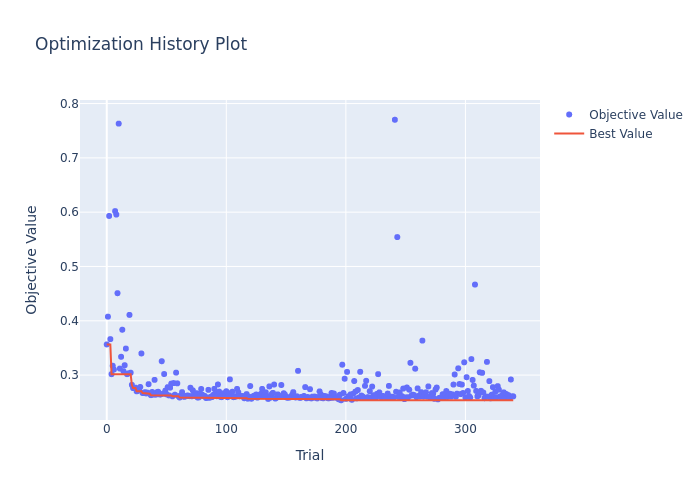

In [12]:
plot_optimization_history(study)

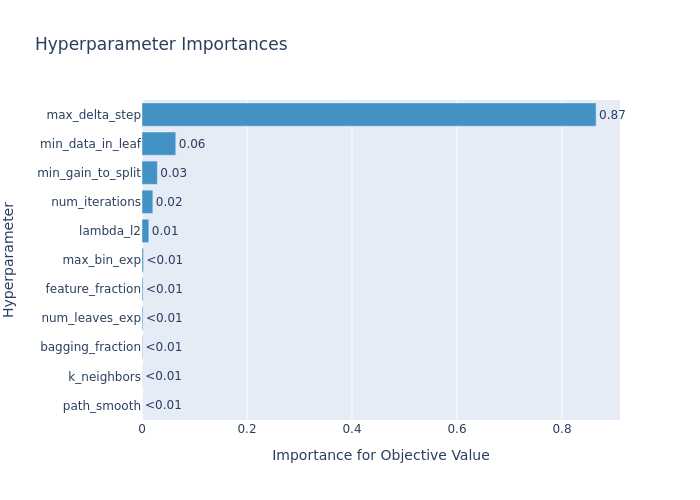

In [13]:
plot_param_importances(study)

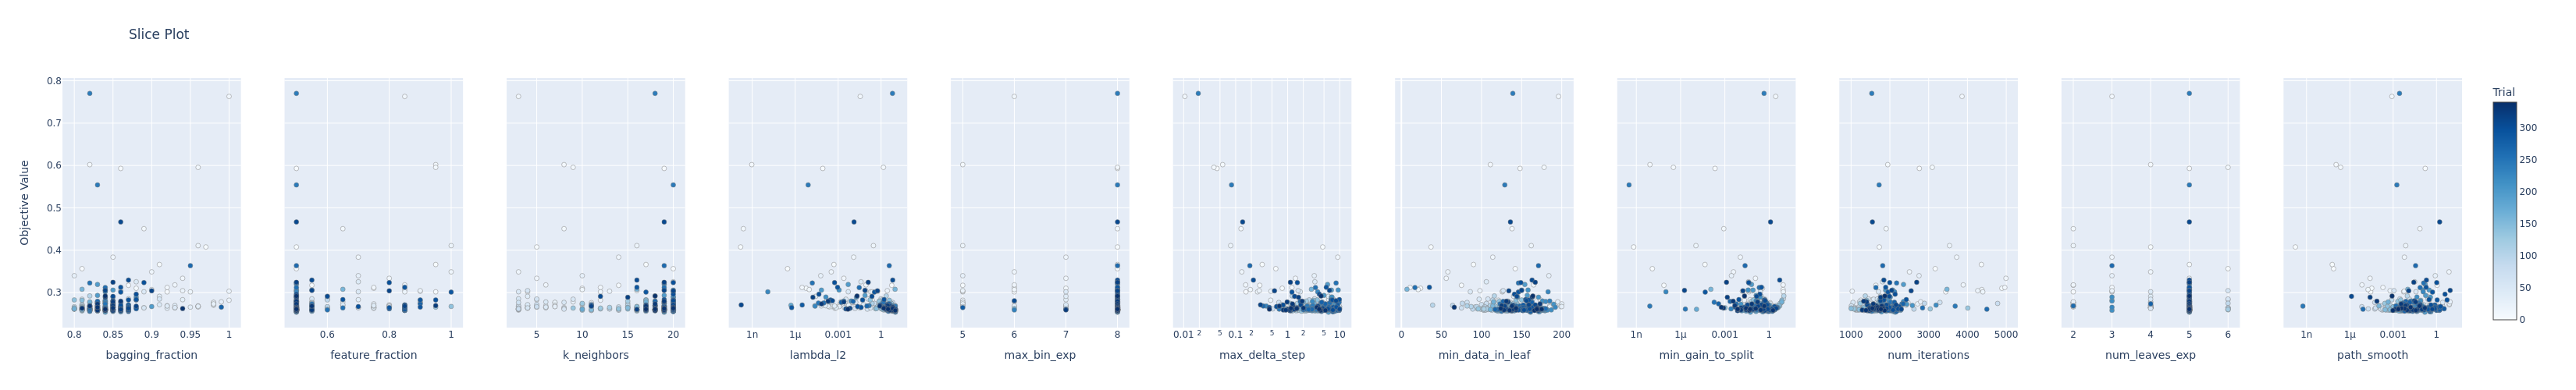

In [14]:
plot_slice(study)

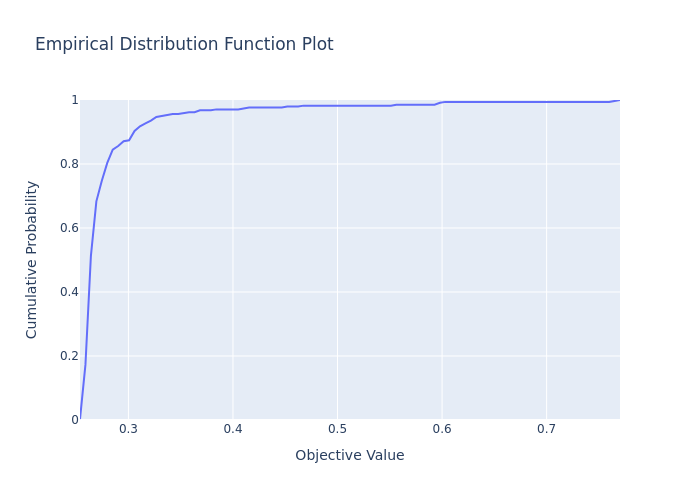

In [15]:
plot_edf(study)

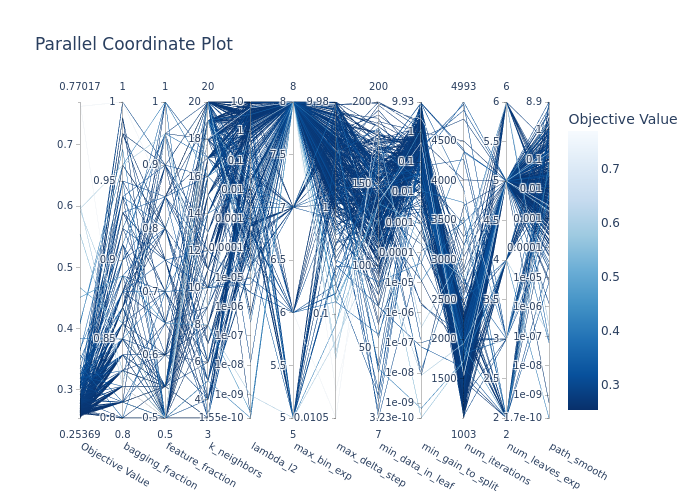

In [16]:
plot_parallel_coordinate(study)

In [17]:
best_params = dict(study.best_params)
best_params["max_bin"] = 2**best_params.pop("max_bin_exp")-1
best_params["num_leaves"] = 2**best_params.pop("num_leaves_exp")-1
best_params = {**DEFAULT_PARAMS, **best_params}
best_params

{'objective': 'multiclass',
 'num_class': 4,
 'metric': 'None',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'seed': 2112,
 'first_metric_only': False,
 'feature_pre_filter': False,
 'verbosity': -1,
 'bagging_fraction': 0.8400000000000001,
 'feature_fraction': 0.5,
 'k_neighbors': 19,
 'lambda_l2': 9.998318198503373,
 'max_delta_step': 6.095391902422209,
 'min_data_in_leaf': 161,
 'min_gain_to_split': 0.05332290158273416,
 'num_iterations': 2139,
 'path_smooth': 0.1580149890665994,
 'max_bin': 255,
 'num_leaves': 31}

***